# French Motor dataset
Goal is to predict if customer will have an accident or not.
Steps:
- Initial analysis (1)
- Data preprocessing (2)
- modelling (3)
- model explanation (4)

In [54]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score,accuracy_score,recall_score,precision_score,roc_auc_score,classification_report
from sklearn.model_selection import cross_val_score

from skopt import BayesSearchCV
from skopt.space import Real, Integer

from catboost import CatBoostClassifier
import xgboost as xgb

from tqdm import tqdm

In [55]:
df_og = pd.read_csv('freMTPL2freq.csv')
df = df_og.copy()

## Description
| Variable     | Description                                                                 |
|--------------|-----------------------------------------------------------------------------|
| IDpol        | Unique identifier for the policy (used to link with claims dataset)         |
| ClaimNb      | Number of claims reported during the policy period                          |
| Exposure     | Duration of the policy (in years, e.g., 1.0 means full year)                |
| Area         | Geographic area code where the policyholder resides                         |
| VehPower     | Vehicle power (ordered categorical)                                          |
| VehAge       | Age of the vehicle in years                                                  |
| DrivAge      | Age of the driver in years                                                   |
| BonusMalus   | Bonus-malus coefficient: <100 is a discount (bonus), >100 is a penalty       |
| VehBrand     | Brand of the vehicle (can include unknown or rare categories)                |
| VehGas       | Type of fuel used by the vehicle: Diesel or regular (gasoline)              |
| Density      | Population density (inhabitants per km²) of the driver’s residence city      |
| Region       | Administrative region in France based on standard regional classification    |

In [56]:
# Display basic information
print("Dataset Shape:", df.shape)
print("\nData Info:")
df.info()

# Display basic statistics
print("\nNumerical Features Statistics:")
print(df.describe())

Dataset Shape: (678013, 12)

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   IDpol       678013 non-null  float64
 1   ClaimNb     678013 non-null  int64  
 2   Exposure    678013 non-null  float64
 3   Area        678013 non-null  object 
 4   VehPower    678013 non-null  int64  
 5   VehAge      678013 non-null  int64  
 6   DrivAge     678013 non-null  int64  
 7   BonusMalus  678013 non-null  int64  
 8   VehBrand    678013 non-null  object 
 9   VehGas      678013 non-null  object 
 10  Density     678013 non-null  int64  
 11  Region      678013 non-null  object 
dtypes: float64(2), int64(6), object(4)
memory usage: 62.1+ MB

Numerical Features Statistics:
              IDpol        ClaimNb       Exposure       VehPower  \
count  6.780130e+05  678013.000000  678013.000000  678013.000000   
mean   2.621857e+06       0.05

In [57]:
df.head(5)

IDpol  ClaimNb  Exposure Area  VehPower  VehAge  DrivAge  BonusMalus  \
0    1.0        1      0.10    D         5       0       55          50   
1    3.0        1      0.77    D         5       0       55          50   
2    5.0        1      0.75    B         6       2       52          50   
3   10.0        1      0.09    B         7       0       46          50   
4   11.0        1      0.84    B         7       0       46          50   

  VehBrand   VehGas  Density Region  
0      B12  Regular     1217    R82  
1      B12  Regular     1217    R82  
2      B12   Diesel       54    R22  
3      B12   Diesel       76    R72  
4      B12   Diesel       76    R72

# Data encoding

In [58]:
numeric_columns = []
string_columns = []
for k,v in df.dtypes.items():
    if v == 'object':
        string_columns.append(k)
    else:
        numeric_columns.append(k)
print('numeric columns:',numeric_columns)
print('string columns:',string_columns)

numeric columns: ['IDpol', 'ClaimNb', 'Exposure', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']
string columns: ['Area', 'VehBrand', 'VehGas', 'Region']


In [59]:
df = pd.get_dummies(df, drop_first=True, dtype='int')
df.head(5)

IDpol  ClaimNb  Exposure  VehPower  VehAge  DrivAge  BonusMalus  Density  \
0    1.0        1      0.10         5       0       55          50     1217   
1    3.0        1      0.77         5       0       55          50     1217   
2    5.0        1      0.75         6       2       52          50       54   
3   10.0        1      0.09         7       0       46          50       76   
4   11.0        1      0.84         7       0       46          50       76   

   Area_B  Area_C  ...  Region_R53  Region_R54  Region_R72  Region_R73  \
0       0       0  ...           0           0           0           0   
1       0       0  ...           0           0           0           0   
2       1       0  ...           0           0           0           0   
3       1       0  ...           0           0           1           0   
4       1       0  ...           0           0           1           0   

   Region_R74  Region_R82  Region_R83  Region_R91  Region_R93  Region_R94  
0           0           1           0           0           0           0  
1           0           1           0           0           0           0  
2           0           0           0           0           0           0  
3           0           0           0           0           0           0  
4           0           0           0           0           0           0  

[5 rows x 45 columns]

In [60]:
# add new created columns to num-cat division
categorical_columns = []
for col in df.columns:
    if col.startswith(tuple(string_columns)):
        categorical_columns.append(col)
numeric_columns = list(set(numeric_columns) - {'IDpol','ClaimNb','Exposure'})
print('numerical:',numeric_columns)
print('categorical:',categorical_columns)

numerical: ['BonusMalus', 'DrivAge', 'Density', 'VehPower', 'VehAge']
categorical: ['Area_B', 'Area_C', 'Area_D', 'Area_E', 'Area_F', 'VehBrand_B10', 'VehBrand_B11', 'VehBrand_B12', 'VehBrand_B13', 'VehBrand_B14', 'VehBrand_B2', 'VehBrand_B3', 'VehBrand_B4', 'VehBrand_B5', 'VehBrand_B6', 'VehGas_Regular', 'Region_R21', 'Region_R22', 'Region_R23', 'Region_R24', 'Region_R25', 'Region_R26', 'Region_R31', 'Region_R41', 'Region_R42', 'Region_R43', 'Region_R52', 'Region_R53', 'Region_R54', 'Region_R72', 'Region_R73', 'Region_R74', 'Region_R82', 'Region_R83', 'Region_R91', 'Region_R93', 'Region_R94']


# Data analysis

## Target

ClaimNb
0     643953
1      32178
2       1784
3         82
4          7
11         3
5          2
6          1
8          1
16         1
9          1
Name: count, dtype: int64


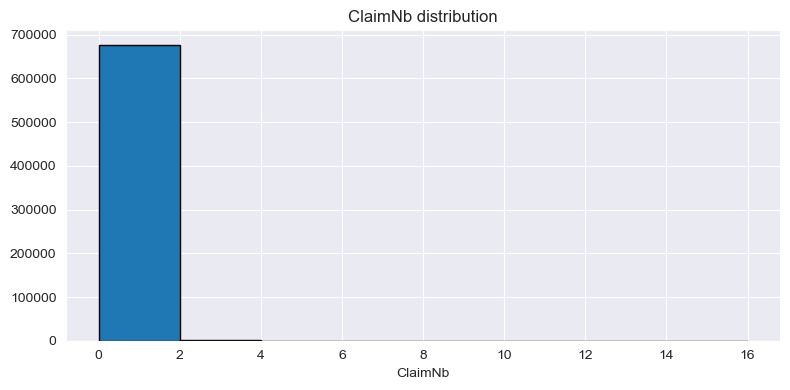

In [62]:
print(df_og['ClaimNb'].value_counts())

# histogram
plt.figure(figsize=(8, 4))
df['ClaimNb'].hist(bins=8, edgecolor='black')
plt.title(f"ClaimNb distribution")
plt.xlabel("ClaimNb")
plt.tight_layout()
plt.show()

In [63]:
df = df[df['ClaimNb'] <= 4]

# add binary target
df['HasClaim'] = (df['ClaimNb'] > 0).astype(int)

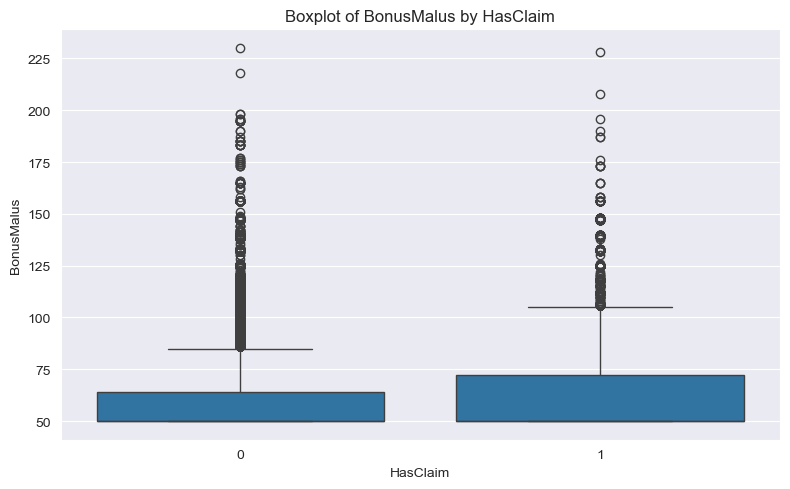

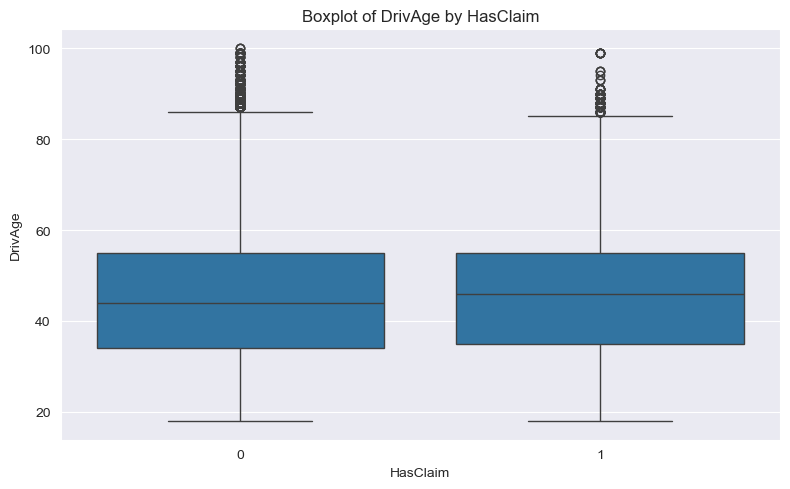

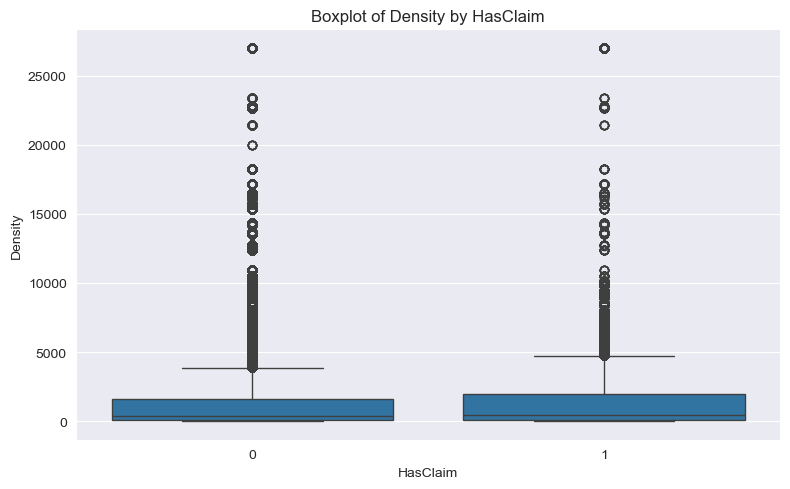

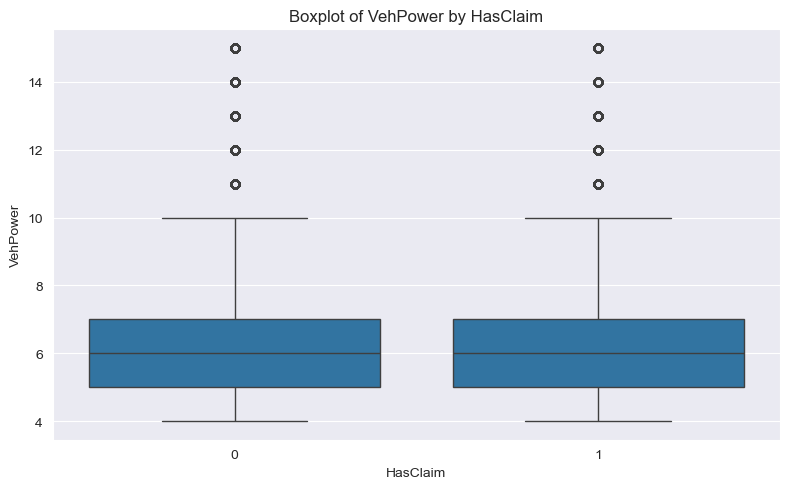

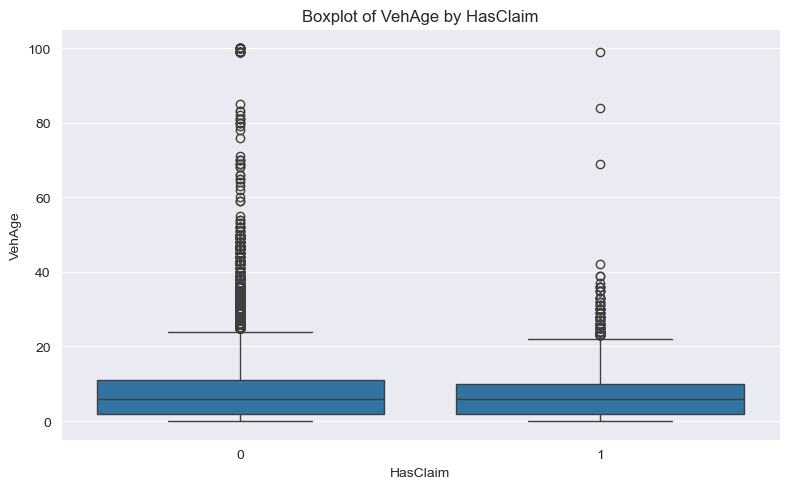

In [64]:
def plot_variables_by_target(df,selected_columns, target='HasClaim'):
    for col in selected_columns:
        plt.figure(figsize=(8, 5))
        sns.boxplot(x=target, y=col, data=df)
        plt.title(f'Boxplot of {col} by {target}')
        plt.tight_layout()
        plt.show()
plot_variables_by_target(df,list(numeric_columns))

## distribution

Exposure
1.00    168125
0.08     44670
0.07     12969
0.24     12950
0.50     12497
         ...  
1.63         1
1.70         1
1.71         1
1.55         1
1.62         1
Name: count, Length: 187, dtype: int64


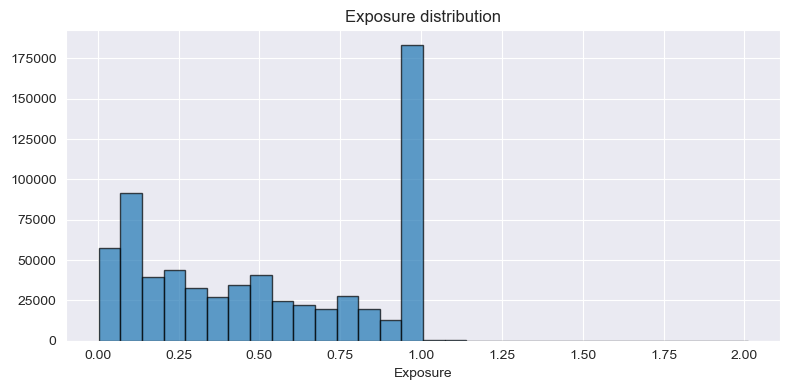

Area
C    191880
D    151596
E    137167
A    103957
B     75459
F     17954
Name: count, dtype: int64


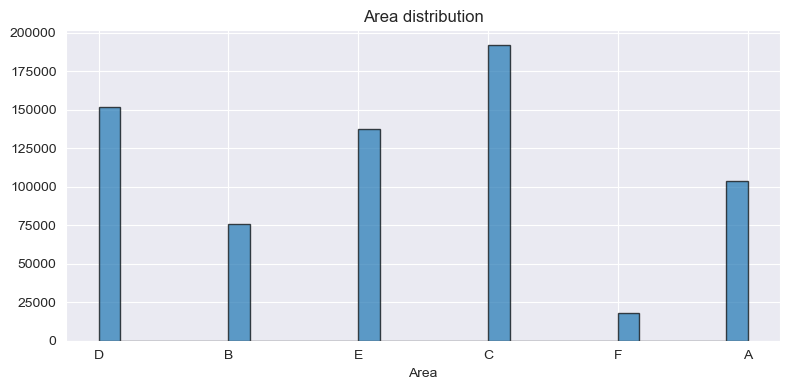

VehPower
6     148976
7     145401
5     124821
4     115349
8      46956
10     31354
9      30085
11     18352
12      8214
13      3229
15      2926
14      2350
Name: count, dtype: int64


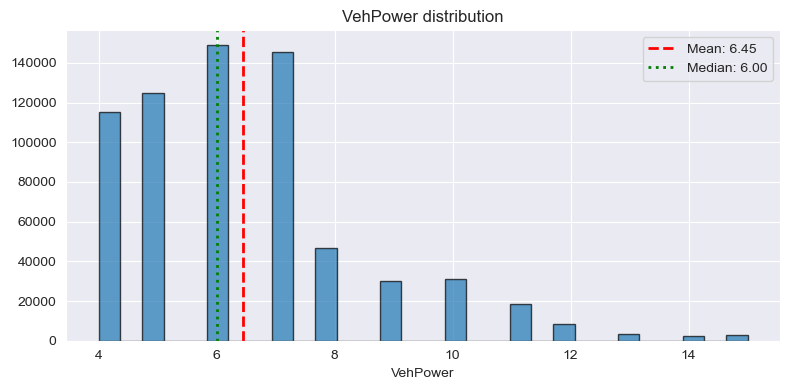

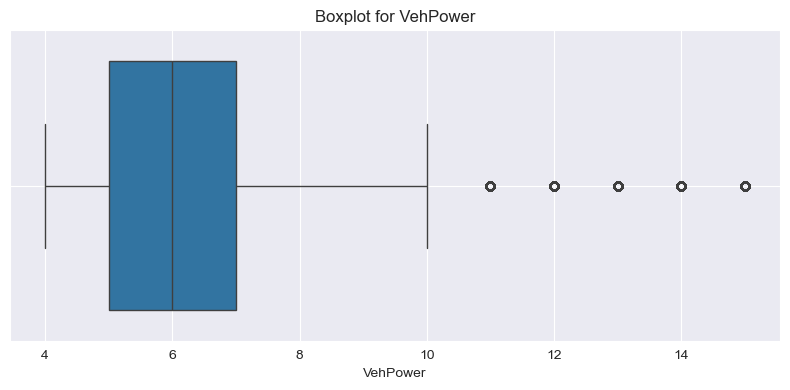

VehAge
1     71284
2     59124
0     57739
3     50261
4     43492
      ...  
62        1
85        1
60        1
63        1
71        1
Name: count, Length: 78, dtype: int64


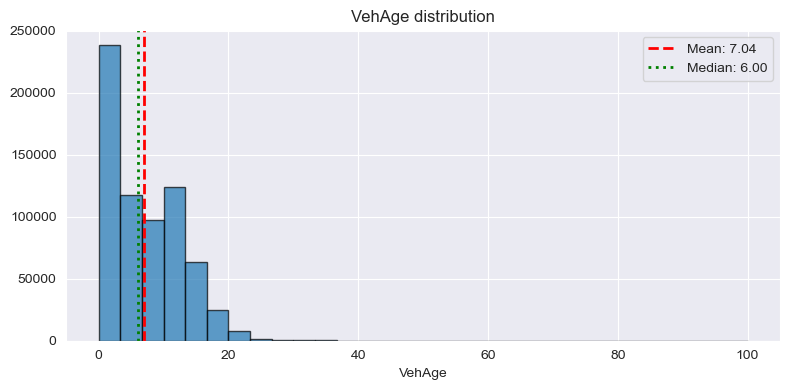

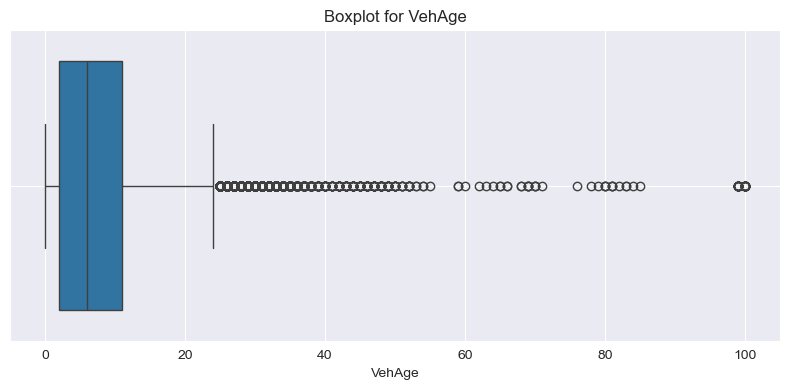

DrivAge
36     17530
38     17346
39     17320
37     17295
52     17195
       ...  
95        24
96        15
97        10
98         5
100        3
Name: count, Length: 83, dtype: int64


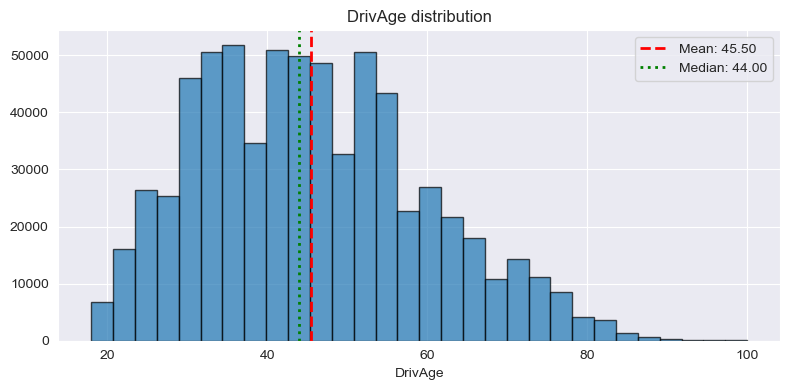

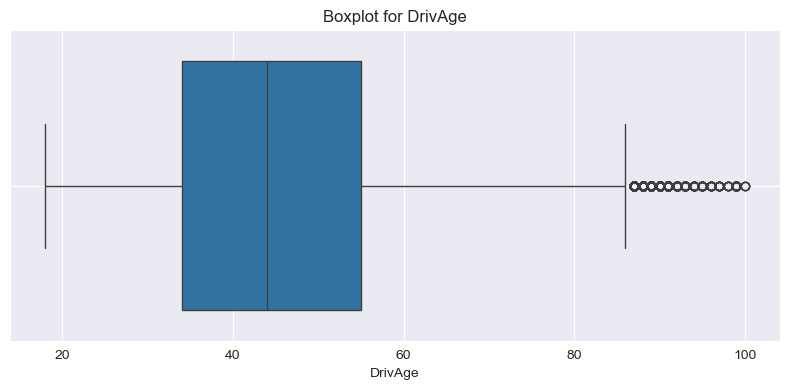

BonusMalus
50     384156
100     19530
68      18791
72      18580
76      18226
        ...  
163         1
136         1
135         1
123         1
218         1
Name: count, Length: 115, dtype: int64


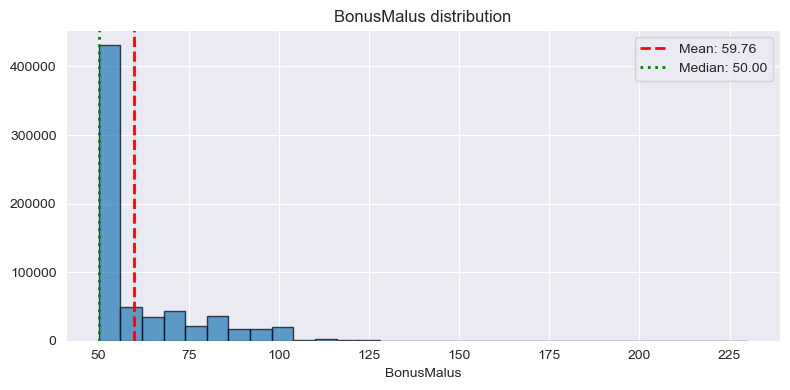

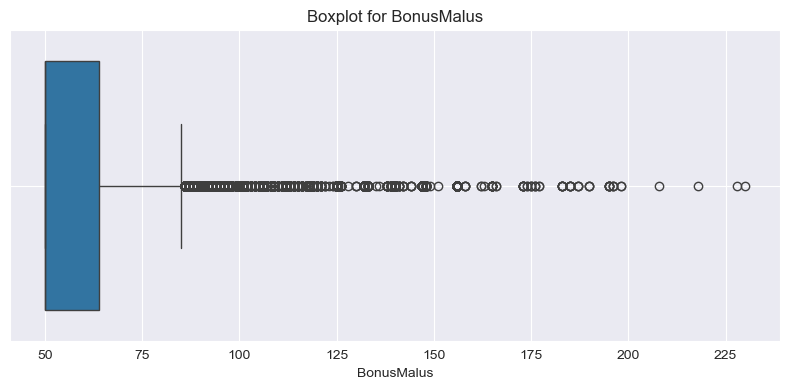

VehBrand
B12    166024
B1     162736
B2     159861
B3      53395
B5      34753
B6      28548
B4      25179
B10     17707
B11     13585
B13     12178
B14      4047
Name: count, dtype: int64


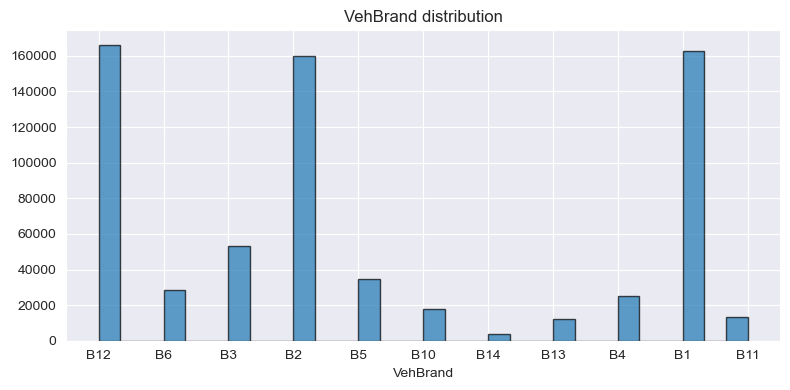

VehGas
Regular    345877
Diesel     332136
Name: count, dtype: int64


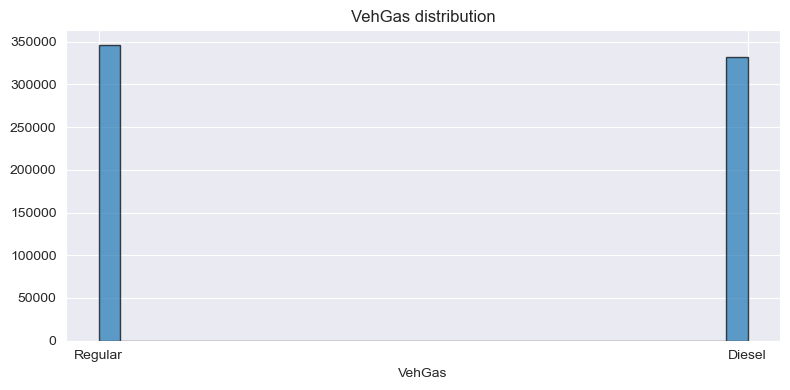

Density
27000    10515
3317      9891
1313      7157
9307      5986
3744      5540
         ...  
773          2
1036         2
1013         2
869          1
1651         1
Name: count, Length: 1607, dtype: int64


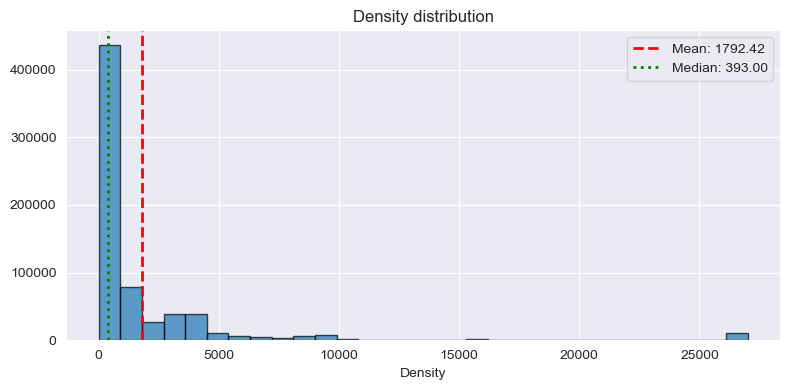

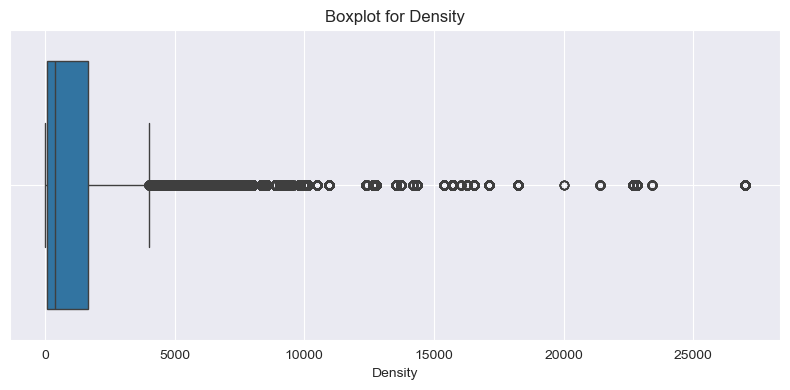

Region
R24    160601
R82     84752
R93     79315
R11     69791
R53     42122
R52     38751
R91     35805
R72     31329
R31     27285
R54     19046
R73     17141
R41     12990
R25     10893
R26     10492
R23      8784
R22      7994
R83      5287
R74      4567
R94      4516
R21      3026
R42      2200
R43      1326
Name: count, dtype: int64


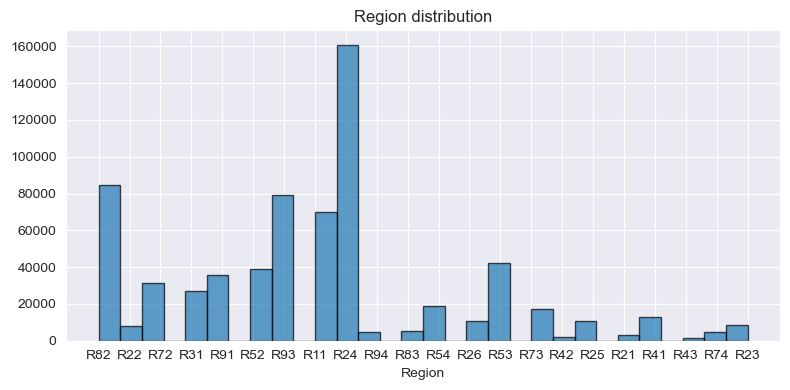

In [65]:
def hist_and_box_df(df):
    for col in df.columns:
        
        # columns to skip
        if col in ['ClaimNb','IDpol']:
            continue
            
        print(df[col].value_counts())

        plt.figure(figsize=(8, 4))
        df[col].hist(bins=30, edgecolor='black', alpha=0.7)
        
        if col in numeric_columns:
            mean_val = df[col].mean()
            median_val = df[col].median()
    
            plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_val:.2f}')
            plt.axvline(median_val, color='green', linestyle='dotted', linewidth=2, label=f'Median: {median_val:.2f}')
            plt.legend()
            
        plt.title(f"{col} distribution")
        plt.xlabel(col)
        
        plt.tight_layout()
        plt.show()
        
        if col in numeric_columns:
            # box plot
            plt.figure(figsize=(8, 4))
            sns.boxplot(x=df[col])
            plt.title(f"Boxplot for {col}")
            plt.xlabel(col)
            plt.grid(True)
            plt.tight_layout()
            plt.show()
hist_and_box_df(df_og)

In [66]:
DROP_OUTLIERS = True

VehAge
1     64403
2     53986
0     51750
3     46404
4     40442
5     36221
10    35839
6     33516
7     30982
8     30857
9     30081
11    27781
12    27481
13    25930
14    23292
15    22207
16    14477
17    10583
18     7800
19     5185
20     3220
21     2097
22     1368
23      874
24      634
25      482
26      351
27      311
29      269
28      261
30      242
31      206
32      147
33      118
34       98
35       87
36       69
37       46
38       35
Name: count, dtype: int64


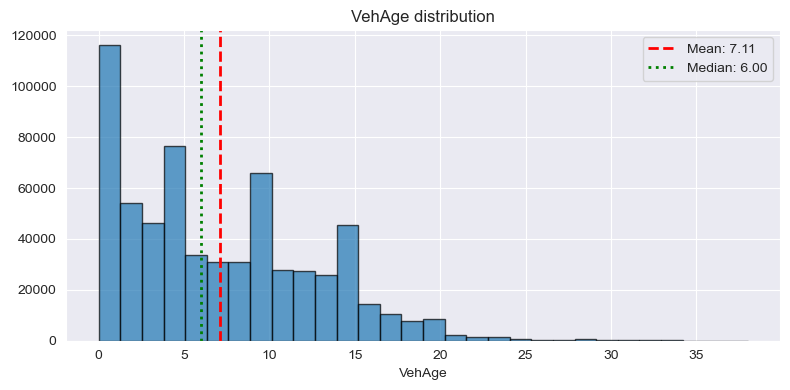

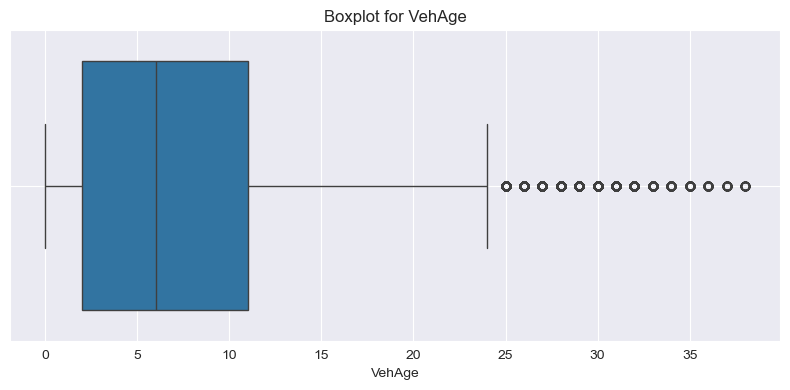

DrivAge
36     16236
52     16074
38     16072
37     16040
39     16001
       ...  
95        22
96        14
97         9
98         4
100        3
Name: count, Length: 83, dtype: int64


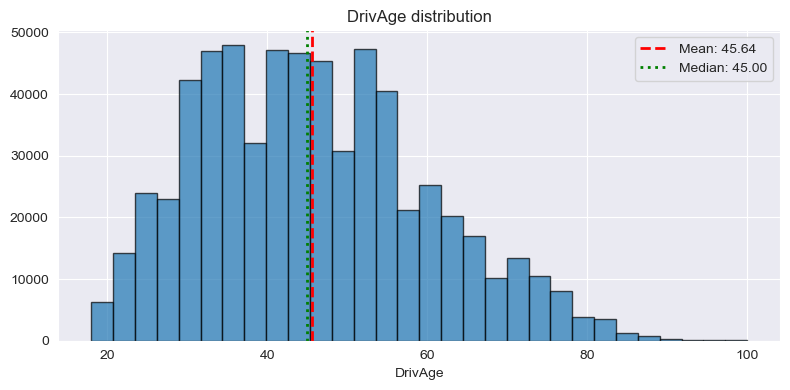

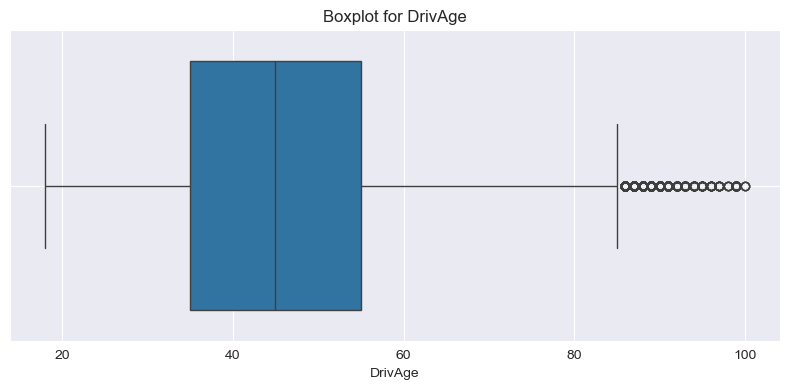

BonusMalus
50     365243
100     17488
68      17382
72      17131
64      16838
76      16598
57      16591
80      16544
54      16123
60      16010
85      15599
90      15345
95      15326
51      14784
62       6710
58       5594
55       5214
52       4392
56       3173
53       3139
63       2898
59       2593
67       2547
71       1867
61       1592
106      1523
65       1416
75       1207
66       1189
69       1000
70        990
73        895
77        857
74        604
78        582
81        462
83        384
88        281
86        267
82        230
79        218
93        171
91        166
87        165
96        124
92        121
84        110
101        96
97         94
99         47
89         45
102        38
94         31
105        30
98         29
103        26
104        13
Name: count, dtype: int64


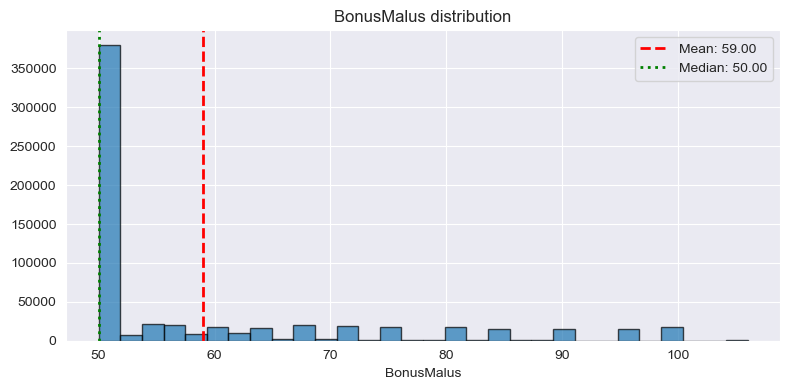

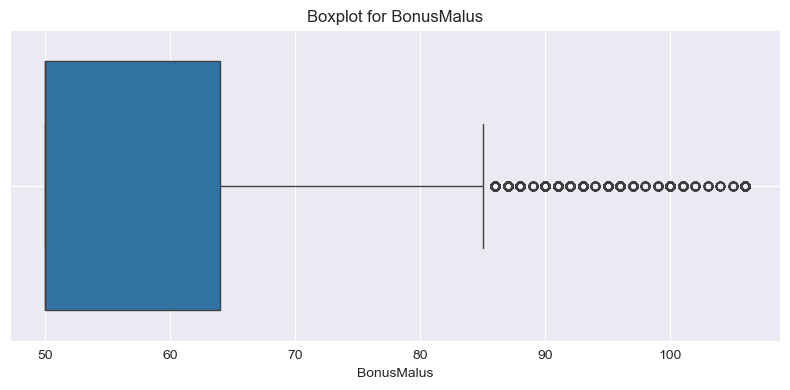

Density
3317    9751
1313    7075
3744    5498
1326    5378
405     5147
        ... 
1394       2
1525       2
1420       2
1651       1
869        1
Name: count, Length: 1522, dtype: int64


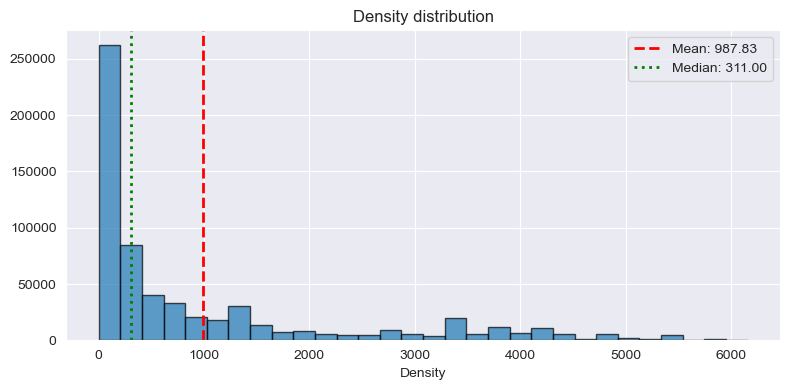

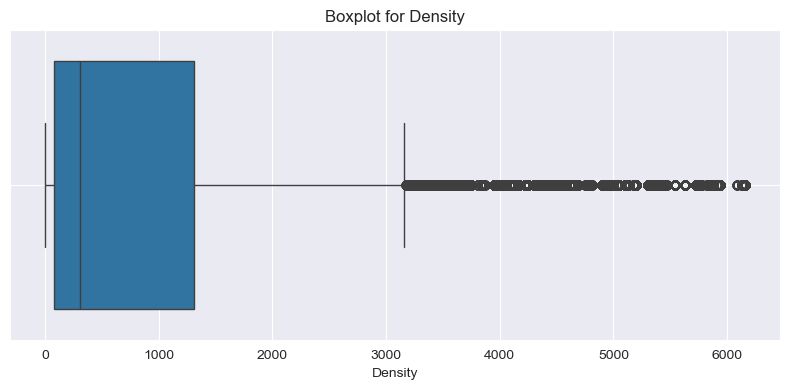

In [67]:
if DROP_OUTLIERS:
    # drop the outliers (only upperbound)
    def drop_outliers_iqr(df, col, multiplier=1.5):
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        #lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        mask = (df[col] <= upper_bound)
        return df[mask]
    
    df = df[df['Exposure'] <= 1]
    
    columns_with_outliers = ['VehAge','DrivAge','BonusMalus','Density']
    for col in columns_with_outliers:
        df = drop_outliers_iqr(df, col,multiplier=3)
    hist_and_box_df(df[columns_with_outliers])

In [68]:
print('og df:',df_og.shape)
print('after removing outliers:',df.shape)

og df: (678013, 12)
after removing outliers: (630132, 46)


## Correlation analysis

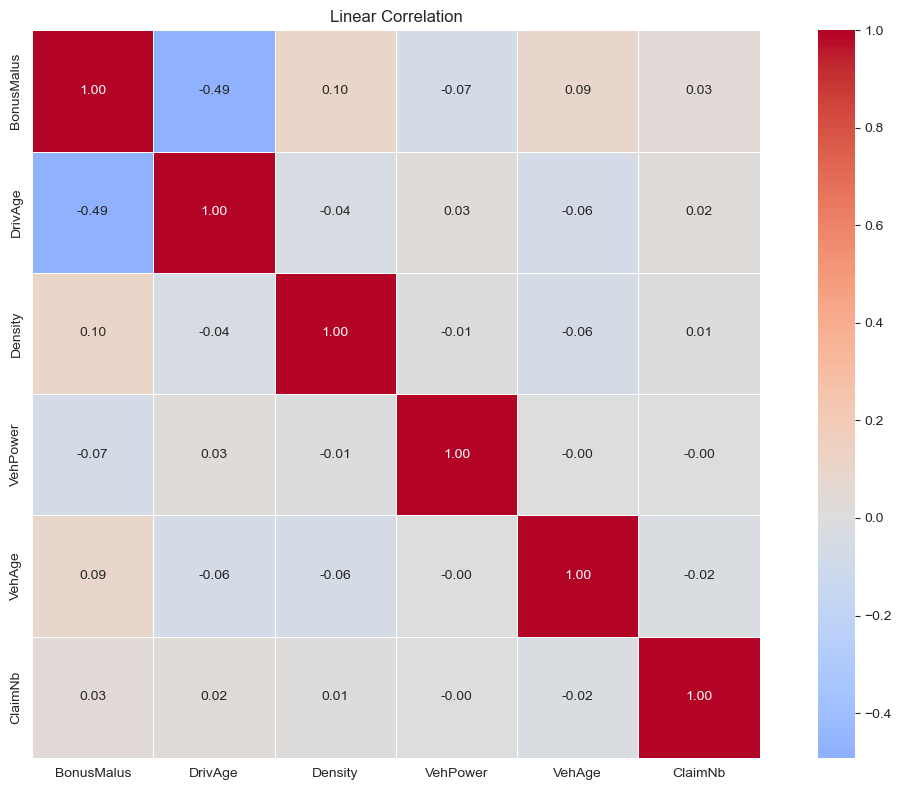

In [69]:
corr = df[numeric_columns+['ClaimNb']].corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, square=True, linewidths=0.5)
plt.title("Linear Correlation")
plt.tight_layout()
plt.show()

## Data division and scaling

In [71]:
# divide into 3 sets for binary classification
X,y = df.drop(columns=['ClaimNb','IDpol','HasClaim'],axis=1), df[['HasClaim','ClaimNb']]
X_train, X_test, y_train, y_test = train_test_split(X, y['HasClaim'], test_size=0.4, random_state=123)
X_val,X_test,y_val,y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=123)

# drop the exposure
exposure_train = X_train['Exposure']
exposure_val = X_val['Exposure']
exposure_test = X_test['Exposure']
X_train.drop('Exposure',axis=1,inplace=True)
X_val.drop('Exposure',axis=1,inplace=True)
X_test.drop('Exposure',axis=1,inplace=True)

# combine train with val for bigger training set
exposure_train_val = np.concatenate([exposure_train, exposure_val], axis=0)
X_train_val = np.concatenate([X_train, X_val], axis=0)
X_train_val = pd.DataFrame(X_train_val, columns=X_train.columns)
y_train_val = np.concatenate([y_train, y_val], axis=0)

In [79]:
# scaling
ss = StandardScaler()
X_train[numeric_columns] = ss.fit_transform(X_train[numeric_columns])
X_val[numeric_columns] = ss.transform(X_val[numeric_columns])
X_test[numeric_columns] = ss.transform(X_test[numeric_columns])
X_train_val[numeric_columns] = ss.transform(X_train_val[numeric_columns])

## Feature Engineering

**The ROC curve** is the plot of the true positive rate (TPR) against the false positive rate (FPR) at each threshold setting.
**ROC AUC** - Receiver Operating Characteristic Area Under Curve

In [18]:
# def evaluate_feature(X_train, y_train, feature, base_score, cv=3):
#     """Adds new feature and check if new feature improves model"""
#     X_copy = X_train.copy()
#     X_copy[feature.name] = feature.values
# 
#     model = sm.GLM(y_train, X_copy, family=sm.families.Binomial(),freq_weights=exposure_train)
#     result = model.fit()
#     y_pred = result.predict(X_copy)
# 
#     new_score = roc_auc_score(y_train,y_pred)
#     print(feature.name,'score:',new_score)
#     return new_score > base_score + 0.001, new_score

In [19]:
# # 1. base model
# X_train_glm = sm.add_constant(X_train)
# model = sm.GLM(y_train, X_train_glm, family=sm.families.Binomial(),freq_weights=exposure_train)
# result = model.fit()
# y_pred = result.predict(X_train_glm)
# 
# # Predict on train
# base_score = roc_auc_score(y_train,y_pred)
# print(f"AUC on train(base_score): {base_score:.4f}")
# 
# # 2. generate new features
# new_features = []
# 
# # Squared
# for col in numeric_columns:
#     new_features.append((f'{col}_squared', X_train[col] ** 2))
# 
# # Sqrt
# for col in numeric_columns:
#     new_features.append((f'{col}_sqrt', np.sqrt(X_train[col])))
# 
# # Log
# for col in numeric_columns:
#     new_features.append((f'{col}_log1p', np.log1p(X_train[col])))
# 
# # Interactions
# for i in range(len(numeric_columns)):
#     for j in range(i+1, len(numeric_columns)):
#         col1 = numeric_columns[i]
#         col2 = numeric_columns[j]
#         new_features.append((f'{col1}_times_{col2}', X_train[col1] * X_train[col2]))
#         new_features.append((f'{col1}_div_{col2}', X_train[col1] / (X_train[col2]+1e-5)))
# 
# # Binning
# for col in numeric_columns:
#     bins = pd.qcut(X_train[col], q=5, labels=False, duplicates='drop')
#     new_features.append((f'{col}_bin', bins))
# print(len(new_features))
# 
# # 3. Test every new feature
# selected_features = {}
# print("\nTesting new features:")
# 
# for name, feat in tqdm(new_features):
#     if bool(feat.isna().sum() > 0):
#         print(f"{name} has null values, skipping...")
#         continue
#     better, new_score = evaluate_feature(X_train_glm, y_train, pd.Series(feat, name=name), base_score)
#     if better:
#         selected_features[name] = feat
#         print(f" Added {name} | new AUC: {base_score:.4f}")

## data preprocessing for GLM

In [80]:
X_train_val_glm = sm.add_constant(X_train_val)
X_test_glm = sm.add_constant(X_test)

In [81]:
# worthy features that improves score of glm, DrivAge_bin, DrivAge_squared

X_train_val_glm['DrivAge_squared'] = X_train_val_glm['DrivAge'] ** 2
bins = pd.qcut(X_train_val_glm['DrivAge'], q=5, labels=False, duplicates='drop')
X_train_val_glm['DrivAge_bin'] = bins

X_test_glm['DrivAge_squared'] = X_test_glm['DrivAge'] ** 2
bins = pd.qcut(X_test_glm['DrivAge'], q=5, labels=False, duplicates='drop')
X_test_glm['DrivAge_bin'] = bins

## Feature importance

ANOVA tests whether the mean values differ significantly across the target classes.
The F-score is high when the between-class variance is large relative to the within-class variance → meaning the feature is useful.

C:\Users\Aycon\anaconda3\envs\cloud\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\Aycon\anaconda3\envs\cloud\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


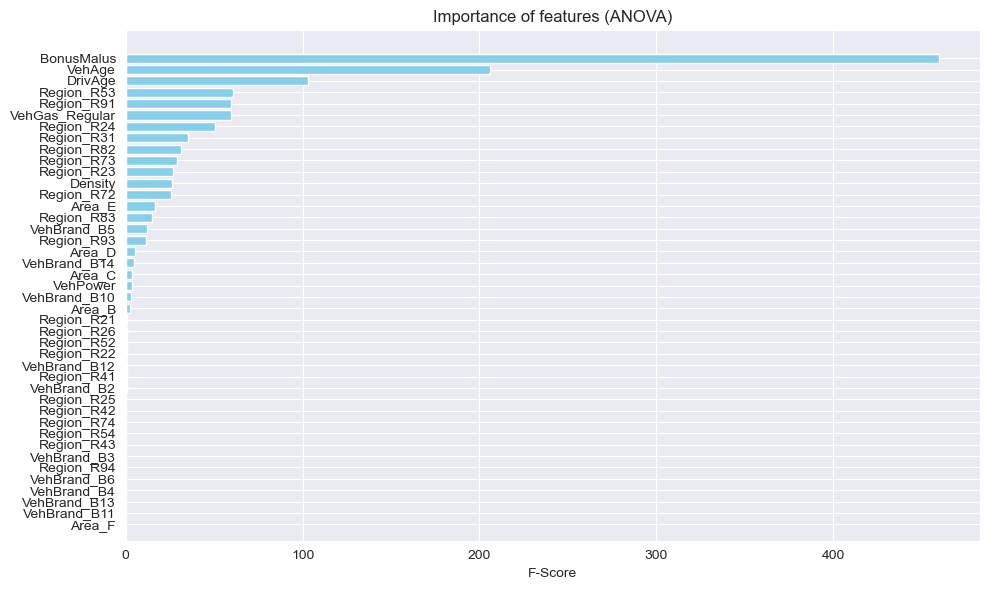

           Feature     F-Score        p-Value
3       BonusMalus  460.036320  5.432221e-102
1           VehAge  206.018323   1.044470e-46
2          DrivAge  102.978795   3.411843e-24
32      Region_R53   60.451730   7.559349e-15
39      Region_R91   59.596601   1.167190e-14
20  VehGas_Regular   59.435766   1.266570e-14
24      Region_R24   50.207649   1.385475e-12
27      Region_R31   35.336566   2.776172e-09
37      Region_R82   31.425655   2.073685e-08
35      Region_R73   29.140325   6.736144e-08
23      Region_R23   26.497845   2.639639e-07
4          Density   26.141939   3.173728e-07
34      Region_R72   25.512101   4.398208e-07
8           Area_E   16.292991   5.427497e-05
38      Region_R83   14.909035   1.128401e-04
18     VehBrand_B5   12.277033   4.586197e-04
40      Region_R93   11.233953   8.032225e-04
7           Area_D    5.405498   2.007395e-02
14    VehBrand_B14    4.917898   2.658044e-02
6           Area_C    3.346214   6.736055e-02
0         VehPower    3.341499   6

In [83]:
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_train, y_train)

scores = selector.scores_
pvalues = selector.pvalues_
feature_scores = pd.DataFrame({
    'Feature': X_train.columns,
    'F-Score': scores,
    'p-Value': pvalues
}).sort_values(by='F-Score', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_scores['Feature'], feature_scores['F-Score'], color='skyblue')
plt.xlabel('F-Score')
plt.title('Importance of features (ANOVA)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(feature_scores)

 # Modelling

In [84]:
def score_binary_model(y,y_pred_proba,selected_thresh=None):
    """Function to score binary model, needs y_pred to be probabilities"""
    
    # roc-auc
    auc_score = roc_auc_score(y, y_pred_proba)
    print('ROC-AUC score:',auc_score)
    
    if not selected_thresh:
        # best threshold
        best_score = -1
        best_thresh = 0
        for i in range(0,100):
            tmp_y_pred = (y_pred_proba > (i/100)).astype(int)
            f_1 = f1_score(y,tmp_y_pred)
            if f_1 > best_score:
                best_score = f_1
                best_thresh = i/100
    else:
        best_thresh = selected_thresh
    y_pred = (y_pred_proba > best_thresh).astype(int)
    
    # other metrics
    f_1 = f1_score(y,y_pred)
    accuracy = accuracy_score(y,y_pred)
    recall = recall_score(y,y_pred)
    precision = precision_score(y,y_pred)
    print("F1-score: ",f_1)
    print("Accuracy:",accuracy)
    print("Recall:",recall)
    print("Precision:",precision)
    
    # confusion matrix
    cm = confusion_matrix(y, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    stats = {
        "roc_auc_score":auc_score,
        "best_threshold":best_thresh,
        "f1-score":f_1,
        "accuracy":accuracy,
        "recall":recall,
        "precision":precision,
        "confusion_matrix":cm
    }
    return stats

def plot_predict_with_feature(X, y, y_pred, feature_name, bins_nb=20):
    """
    Plots feature(histogram) with y_pred and y_true.
    """
    
    df_help = pd.DataFrame({
        feature_name: X[feature_name],
        'y_true': y,
        'y_pred': y_pred,
    })

    unique_values_nb = X[feature_name].nunique()
    if unique_values_nb < bins_nb:
        bins_nb = unique_values_nb

    df_help['bin'] = pd.cut(df_help[feature_name], bins=bins_nb)

    # Grouping by bin
    df_grouped = df_help.groupby('bin', observed=True).agg({
        'y_true': 'mean',
        'y_pred': 'mean',
        feature_name: 'count'
    }).rename(columns={feature_name: 'count'}).reset_index()

    # Dodajemy indeks binów i lewą granicę binu jako label
    df_grouped['bin_idx'] = range(len(df_grouped))
    df_grouped['bin_left'] = df_grouped['bin'].apply(lambda x: x.left)

    # Plotting
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.bar(df_grouped['bin_idx'], df_grouped['count'], color='lightblue', alpha=0.9, label='quantity')
    
    ax2 = ax1.twinx()
    ax2.plot(df_grouped['bin_idx'], df_grouped['y_pred'], color='blue', label='mean of predicted values')
    ax2.plot(df_grouped['bin_idx'], df_grouped['y_true'], color='green', label='mean of true values')

    # Zmiana etykiet osi X na wartości graniczne binów
    ax1.set_xticks(df_grouped['bin_idx'])
    ax1.set_xticklabels([f'{val:.2f}' for val in df_grouped['bin_left']], rotation=45)

    ax1.set_xlabel(f'{feature_name} (bin start)')
    ax1.set_ylabel('quantity')
    ax2.set_ylabel('mean value')

    fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
    plt.title(f'Histogram {feature_name} + predicted values vs true values')
    plt.tight_layout()
    plt.grid(True)
    plt.show()

In [87]:
models_stats_train = {}
models_stats_test = {}

# for plotting
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# for improving recall
weights = compute_sample_weight(class_weight='balanced', y=y_train_val)
weights_with_exposure_val_train = exposure_train_val * weights

In [88]:
# only for plotting
exposure_train_val_df = pd.DataFrame(np.array(exposure_train_val).reshape(-1, 1), columns=['exposure'])
exposure_test_df = pd.DataFrame(np.array(exposure_test).reshape(-1, 1), columns=['exposure'])

## baseline model (random prediction)

ROC-AUC score: 0.4996049166494633
F1-score:  0.04810815199740175
Accuracy: 0.9069757292627528
Recall: 0.04793883247704195
Precision: 0.04827867182725606


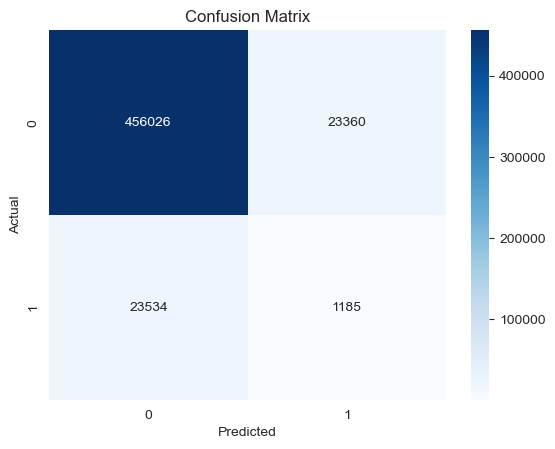

In [89]:
dummy = DummyClassifier(strategy='stratified')
dummy.fit(X_train,y_train)
dummy_pred = dummy.predict_proba(X_train_val)[:,1]

stats = score_binary_model(y_train_val,dummy_pred)

models_stats_train['dummy_classifier'] = stats
models_stats_test['dummy_classifier'] = stats

## Binary Classification

### GLM

In [92]:
model_bin = sm.GLM(y_train_val, X_train_val_glm, family=sm.families.Binomial(),freq_weights=exposure_train_val)
result_bin = model_bin.fit()

print(result_bin.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:               504105
Model:                            GLM   Df Residuals:                268612.28
Model Family:                Binomial   Df Model:                           43
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -59405.
Date:                Tue, 06 May 2025   Deviance:                   1.1881e+05
Time:                        15:57:06   Pearson chi2:                 2.68e+05
No. Iterations:                     6   Pseudo R-squ. (CS):           0.004060
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -2.7563      0.068    -

TRAIN SCORING
ROC-AUC score: 0.5858560452154848
F1-score:  0.1150129108704735
Accuracy: 0.7436863351881057
Recall: 0.3396577531453538
Precision: 0.06922709058227931


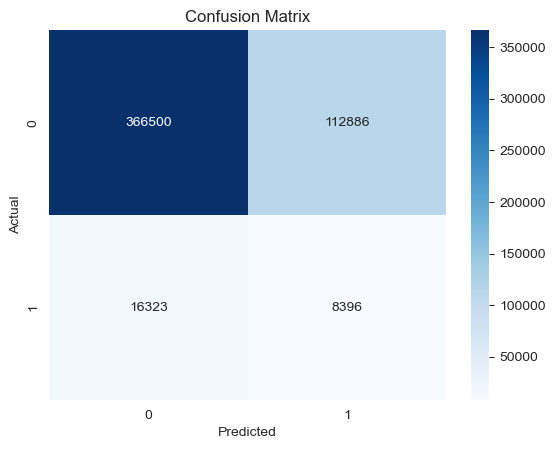

TEST SCORING
ROC-AUC score: 0.5871761098129238
F1-score:  0.11175612842875615
Accuracy: 0.7438247359692765
Recall: 0.334320987654321
Precision: 0.06709170190274842


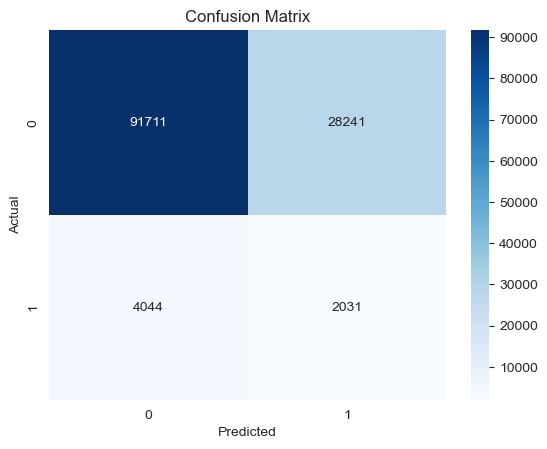

In [93]:
y_pred = result_bin.predict(X_train_val_glm)
print("TRAIN SCORING")
stats = score_binary_model(y_train_val,y_pred)
models_stats_train['glm_train'] = stats

y_pred = result_bin.predict(X_test_glm)
print("TEST SCORING")
stats = score_binary_model(y_test,y_pred,models_stats_train['glm_train']['best_threshold'])
models_stats_test['glm_test'] = stats

PLOTS FOR TEST-SET


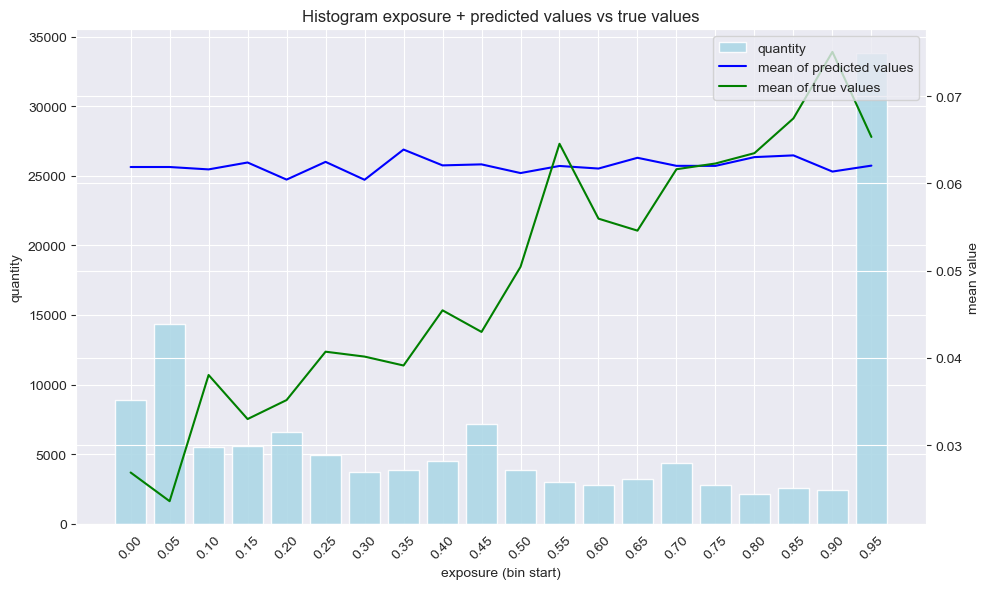

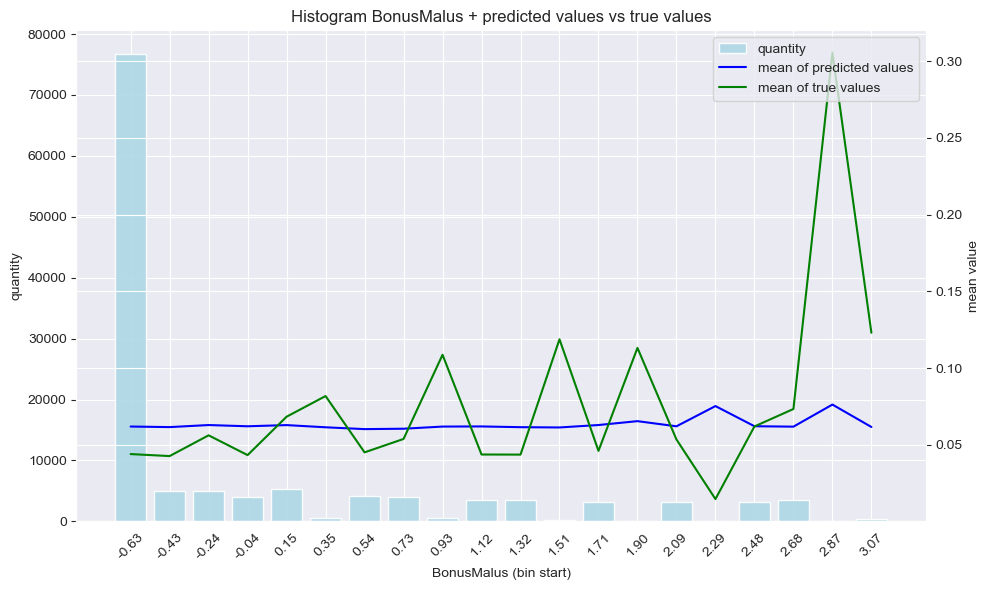

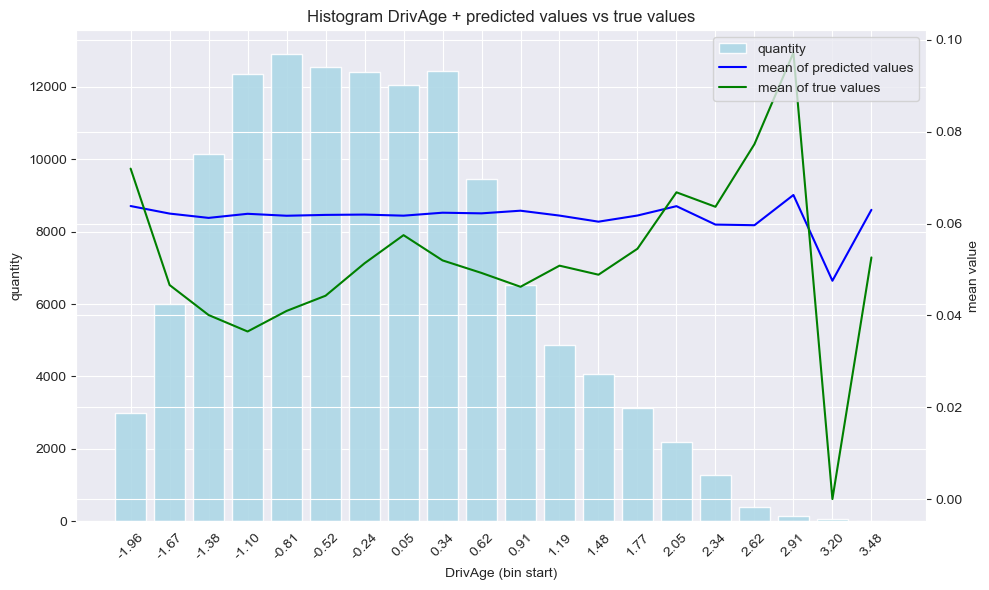

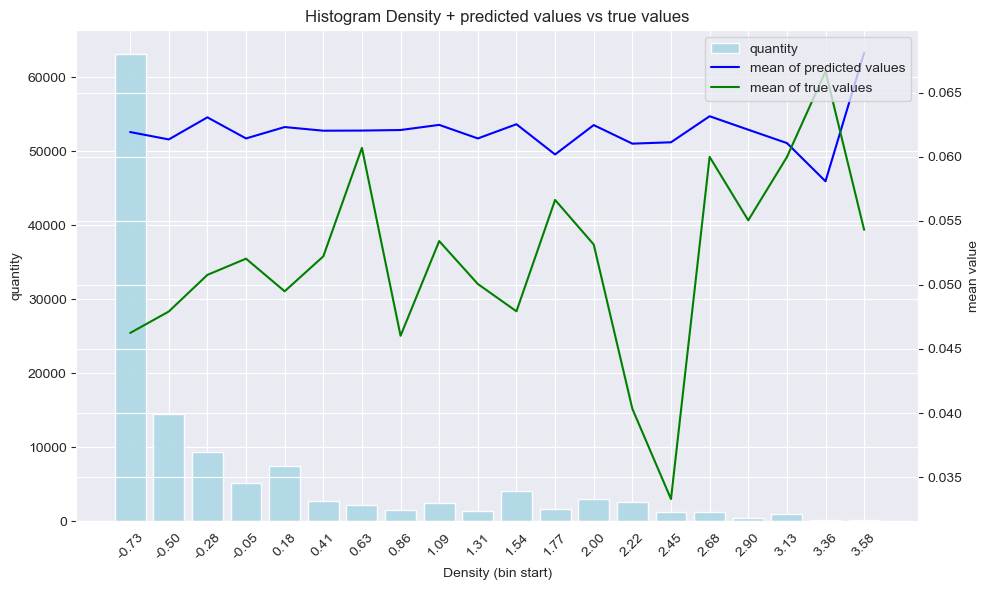

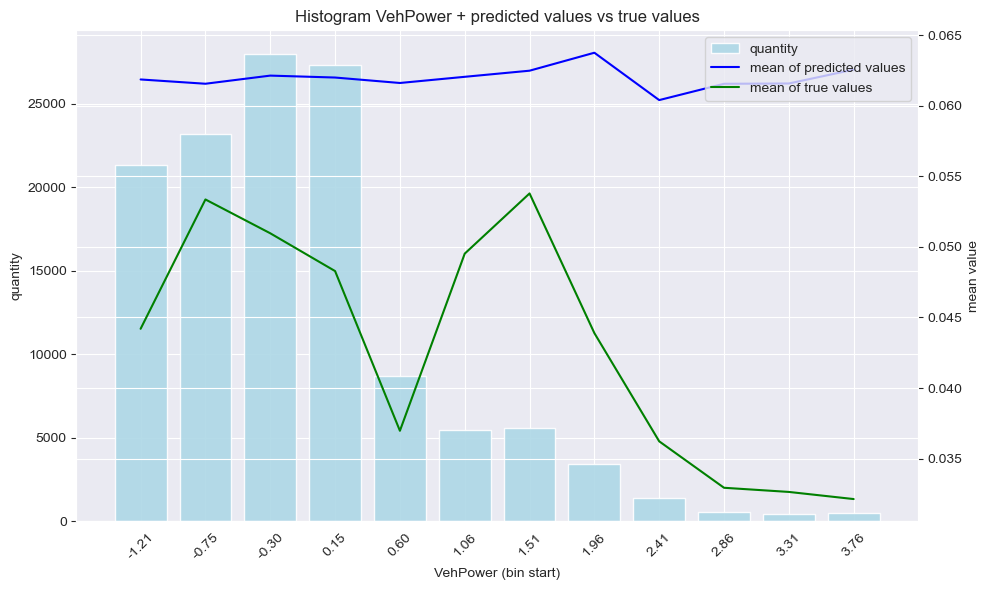

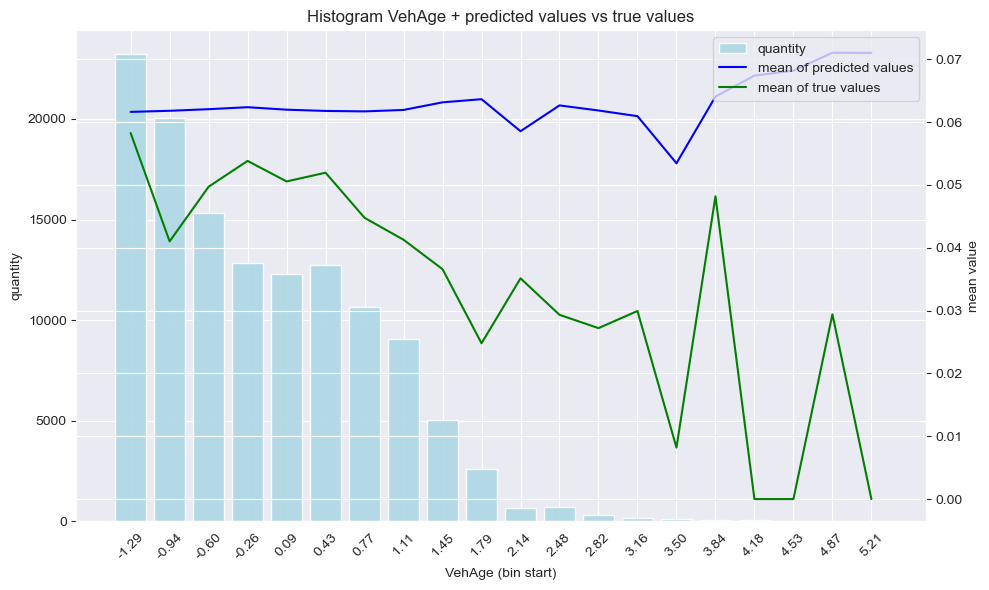

In [29]:
print("PLOTS FOR TEST-SET")
plot_predict_with_feature(exposure_test_df,y_test,y_pred,'exposure')
for col in numeric_columns:
    plot_predict_with_feature(X_test,y_test,y_pred,col)

### GBM

#### Fine-tuning

In [30]:
# # fine-tuning
# gbc = GradientBoostingClassifier()
# 
# search_spaces = {
#     'n_estimators': Integer(100, 600),
#     'learning_rate': Real(0.01, 0.2, prior='log-uniform'),
#     'max_depth': Integer(2, 20),
#     'min_samples_leaf': Integer(1, 30),
#     'subsample': Real(0.6, 1.0),
#     'max_features': Real(0.5, 1.0)
# }
# 
# 
# opt = BayesSearchCV(
#     estimator=gbc,
#     search_spaces=search_spaces,
#     n_iter=20,
#     scoring=make_scorer(f1_score),
#     cv=3,
#     n_jobs=-1,
#     verbose=1,
#     random_state=42
# )
# 
# 
# opt.fit(X_train_val, y_train_val, sample_weight=exposure_train_val) 
# 
# print("Best params:", opt.best_params_)
# print("F1 score:", opt.best_score_)

#### final gbm

In [31]:
model = GradientBoostingClassifier(max_depth=10,min_samples_leaf=1,n_estimators=400,max_features=1.0,learning_rate=0.10)
model.fit(X_train, y_train, sample_weight=exposure_train)

GradientBoostingClassifier(max_depth=10, max_features=1.0, n_estimators=400)

TRAIN-SET SCORING
ROC-AUC score: 0.9587496036882365
F1-score:  0.7438777605067894
Accuracy: 0.9769016528291706
Recall: 0.6828926821388186
Precision: 0.8168233930181631


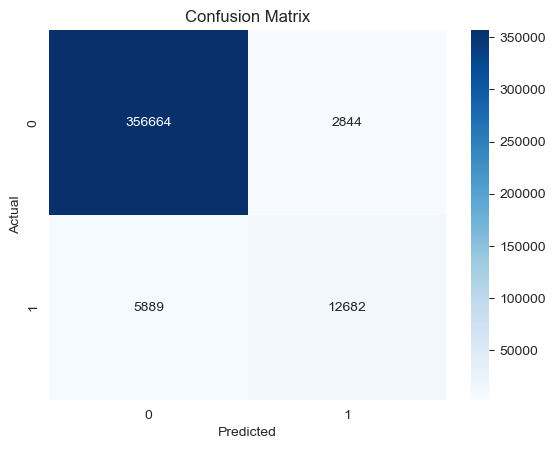

VAL-SET SCORING
ROC-AUC score: 0.6204979175966179
F1-score:  0.15972611266728914
Accuracy: 0.8928871820100615
Recall: 0.2086857514638907
Precision: 0.12937380256125844


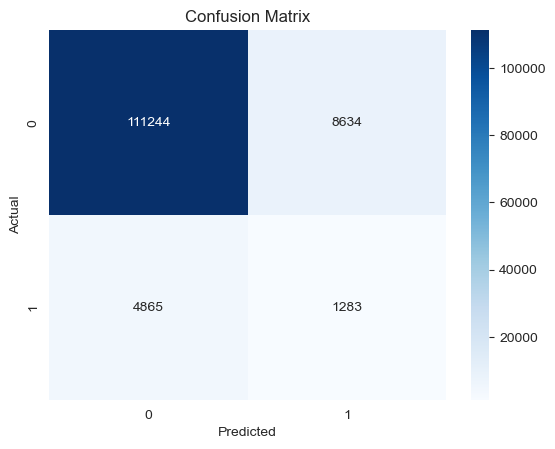

In [32]:
print("TRAIN-SET SCORING")
y_pred = model.predict_proba(X_train)[:, 1]
score_binary_model(y_train, y_pred)

print("VAL-SET SCORING")
y_pred = model.predict_proba(X_val)[:, 1]
stats = score_binary_model(y_val, y_pred)
best_threshold = stats['best_threshold']

In [33]:
model = GradientBoostingClassifier(max_depth=10,min_samples_leaf=1,n_estimators=400,max_features=1.0,learning_rate=0.10)
model.fit(X_train_val, y_train_val, sample_weight=exposure_train_val)

GradientBoostingClassifier(max_depth=10, max_features=1.0, n_estimators=400)

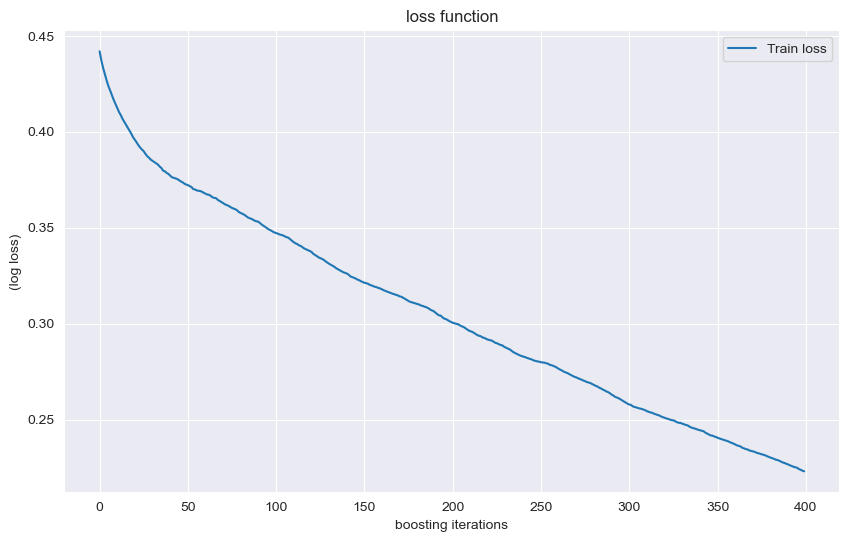

In [34]:
train_loss = model.train_score_

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train loss')
plt.xlabel('boosting iterations')
plt.ylabel('(log loss)')
plt.title('loss function')
plt.legend()
plt.grid(True)
plt.show()

TRAIN-SET SCORING
ROC-AUC score: 0.94224552059756
F1-score:  0.6837362833437416
Accuracy: 0.9718709395859989
Recall: 0.6200898094583114
Precision: 0.7619426355818462


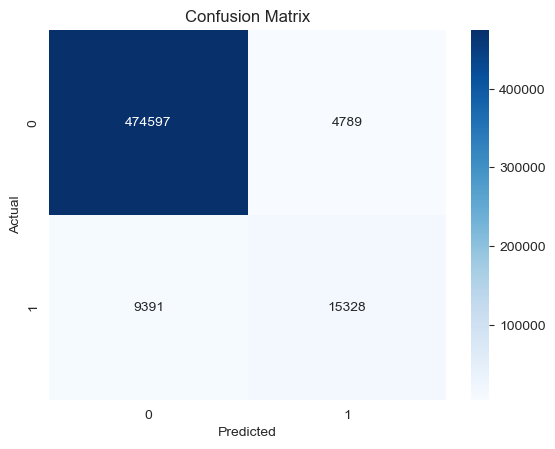

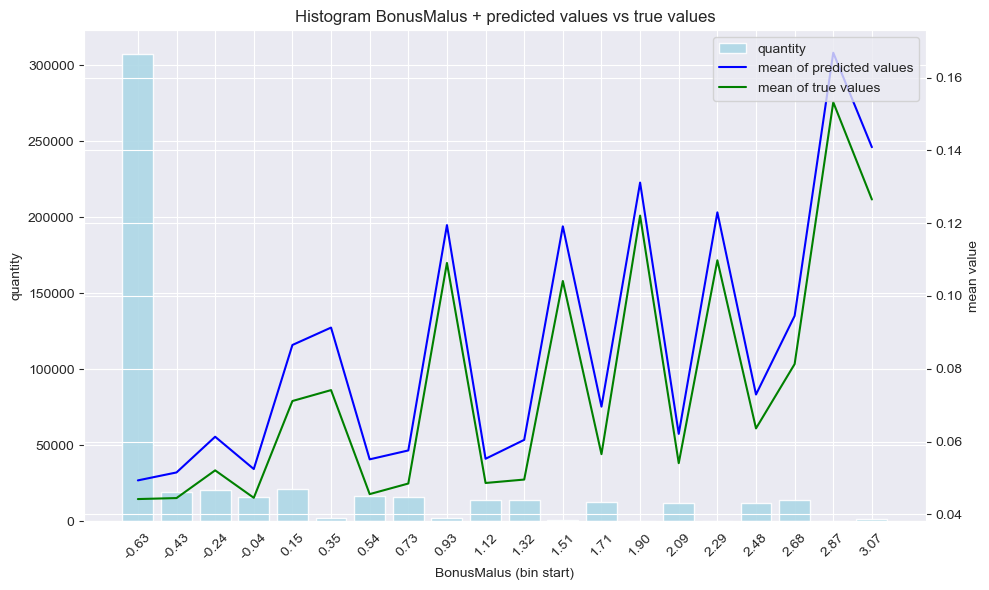

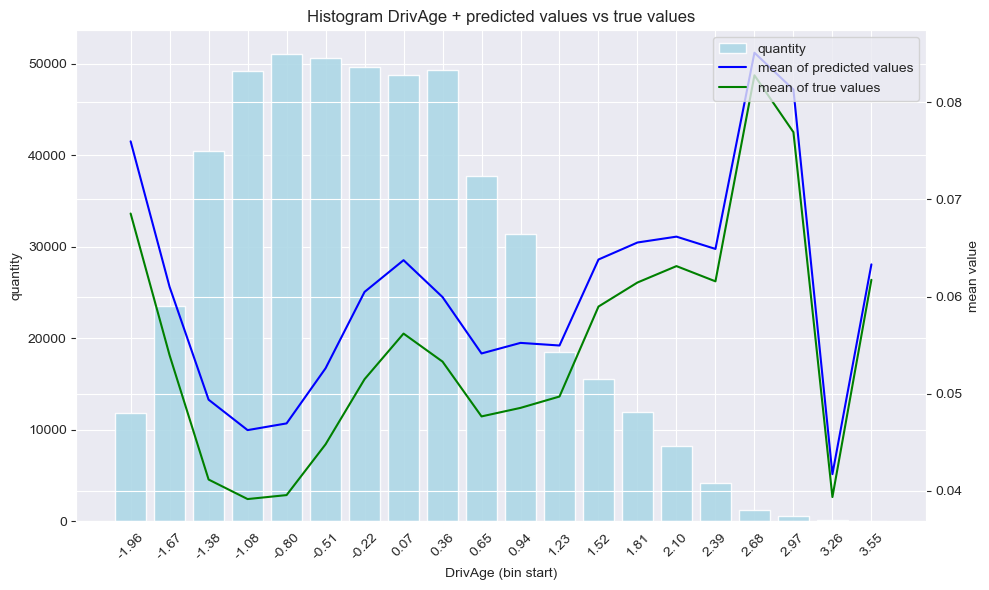

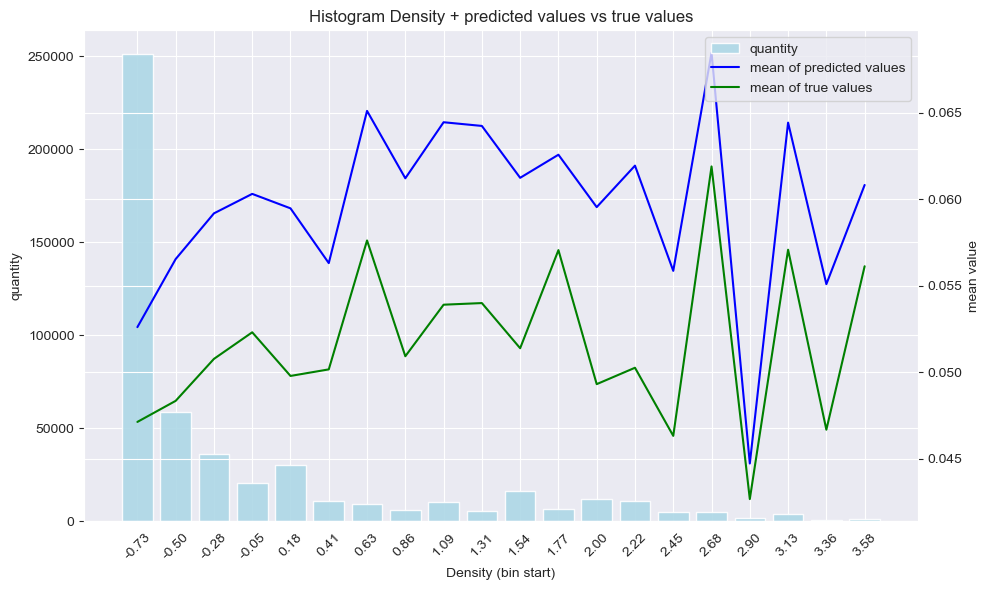

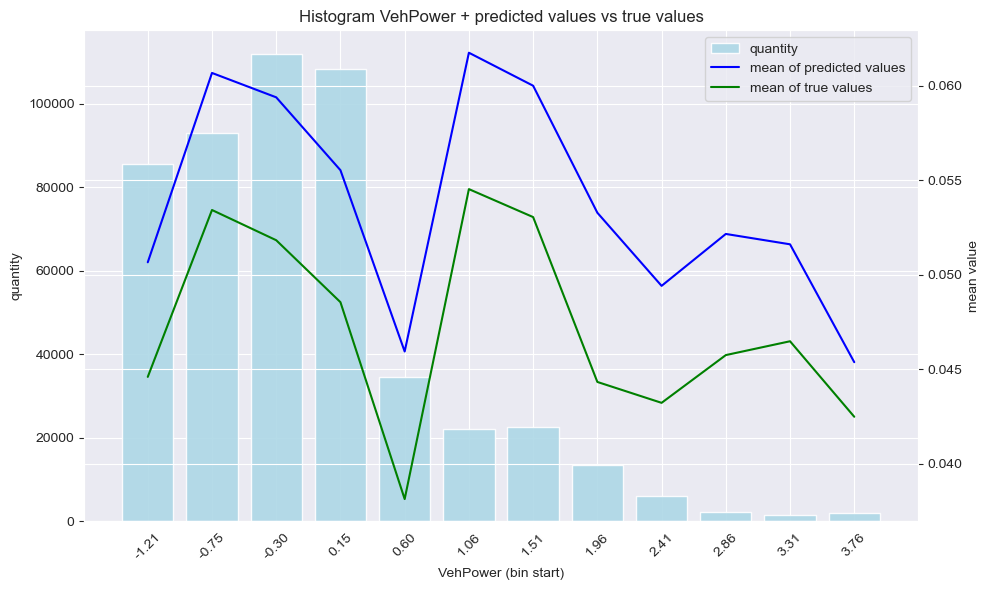

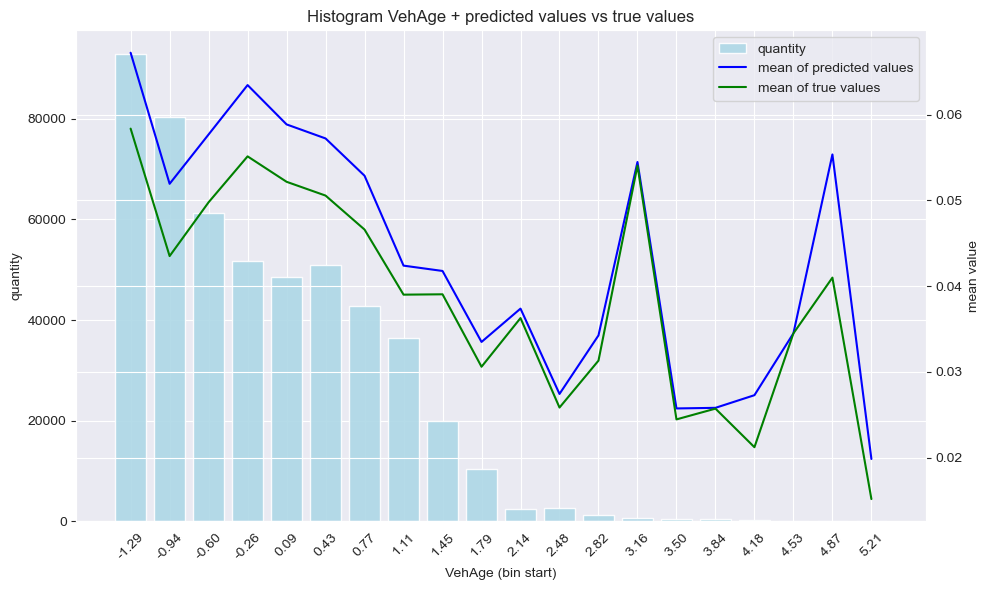

In [35]:
print("TRAIN-SET SCORING")
X_train_val = pd.DataFrame(X_train_val, columns=X_train.columns)
y_pred = model.predict_proba(X_train_val)[:,1]

stats = score_binary_model(y_train_val,y_pred)
models_stats_train['gbm_train'] = stats

for col in numeric_columns:
    plot_predict_with_feature(X_train_val,y_train_val,y_pred,col)

TEST-SET SCORING
ROC-AUC score: 0.6394605345567581
F1-score:  0.1628773760715617
Accuracy: 0.8930705325049394
Recall: 0.21580246913580248
Precision: 0.1307991619275666


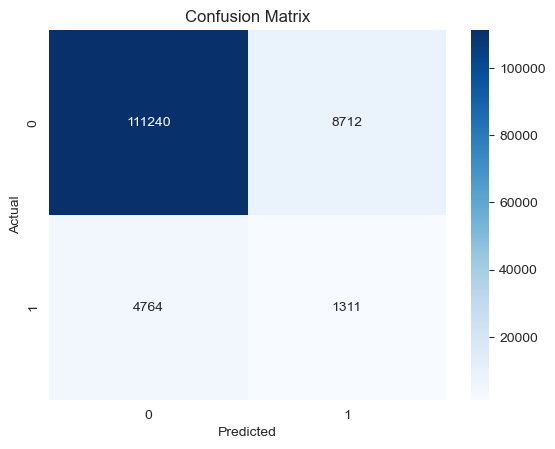

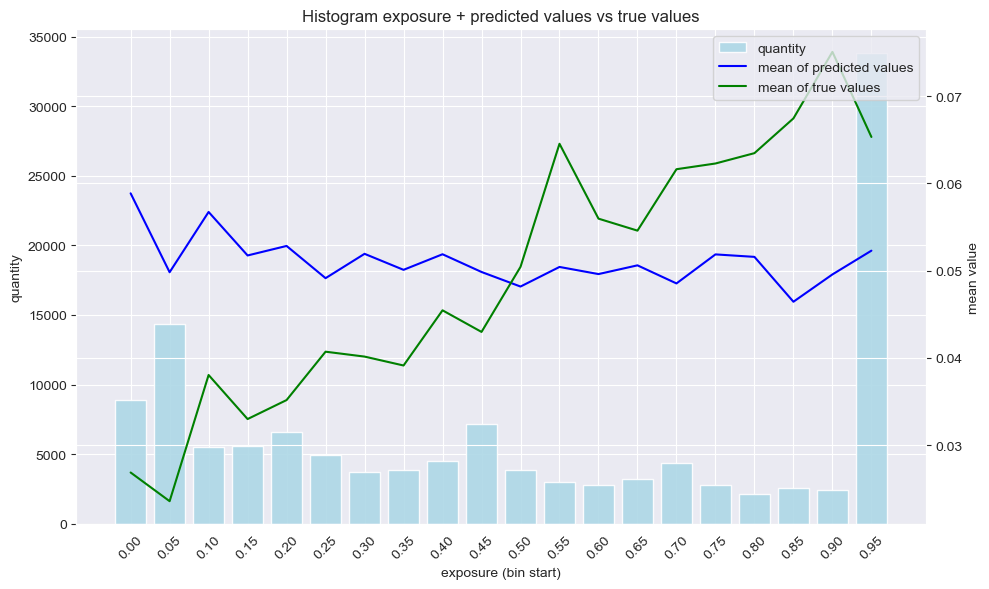

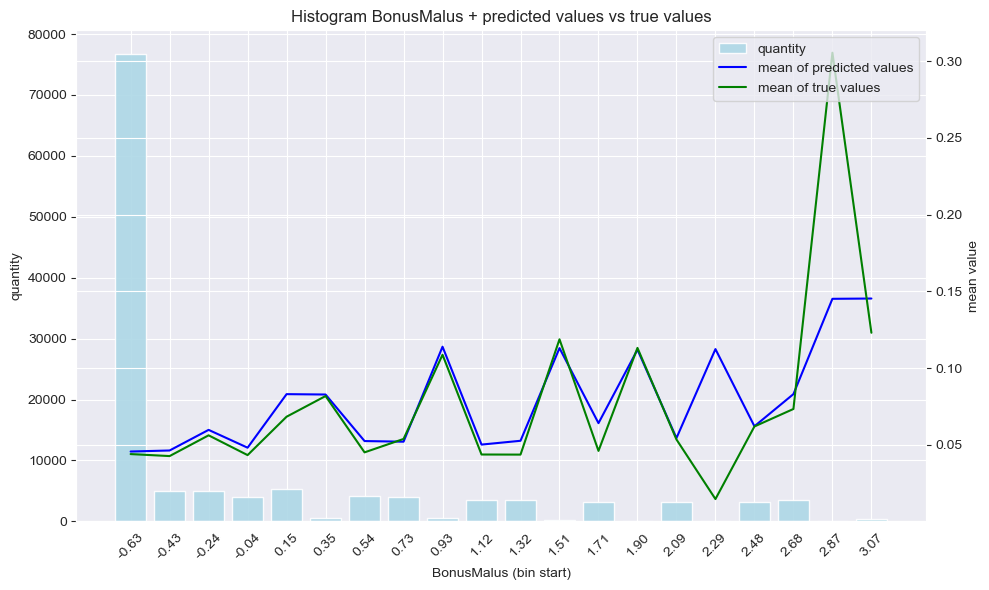

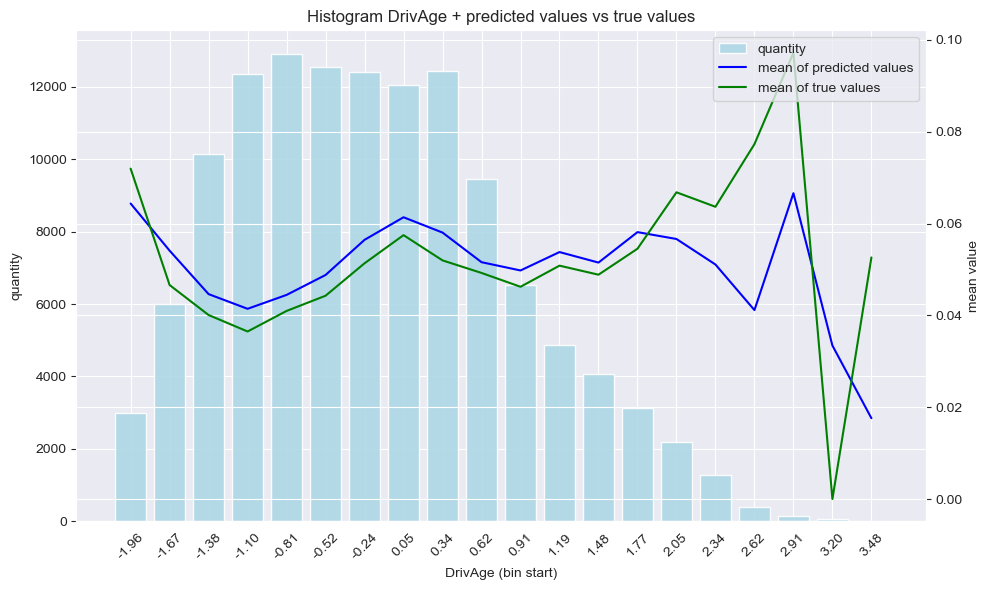

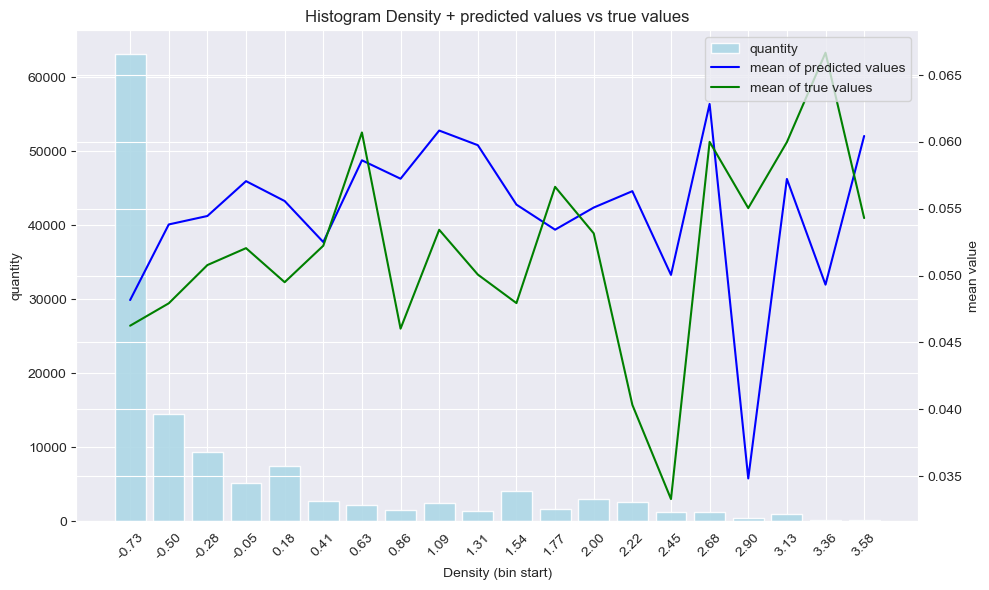

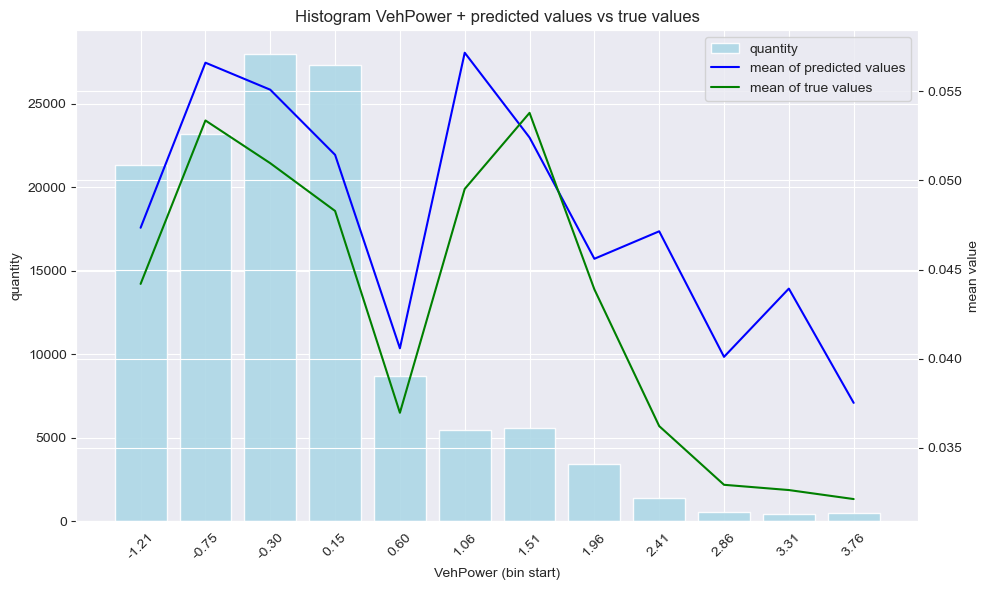

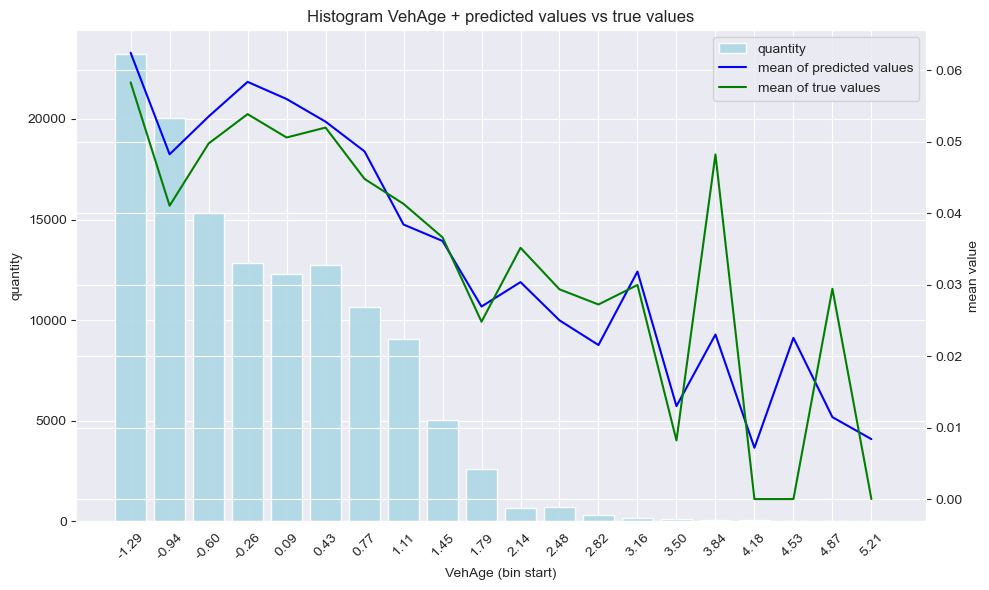

In [36]:
print("TEST-SET SCORING")
y_pred = model.predict_proba(X_test)[:,1]

stats = score_binary_model(y_test,y_pred,best_threshold)
models_stats_test['gbm_test'] = stats

plot_predict_with_feature(exposure_test_df,y_test,y_pred,'exposure')
for col in numeric_columns:
    plot_predict_with_feature(X_test,y_test,y_pred,col)

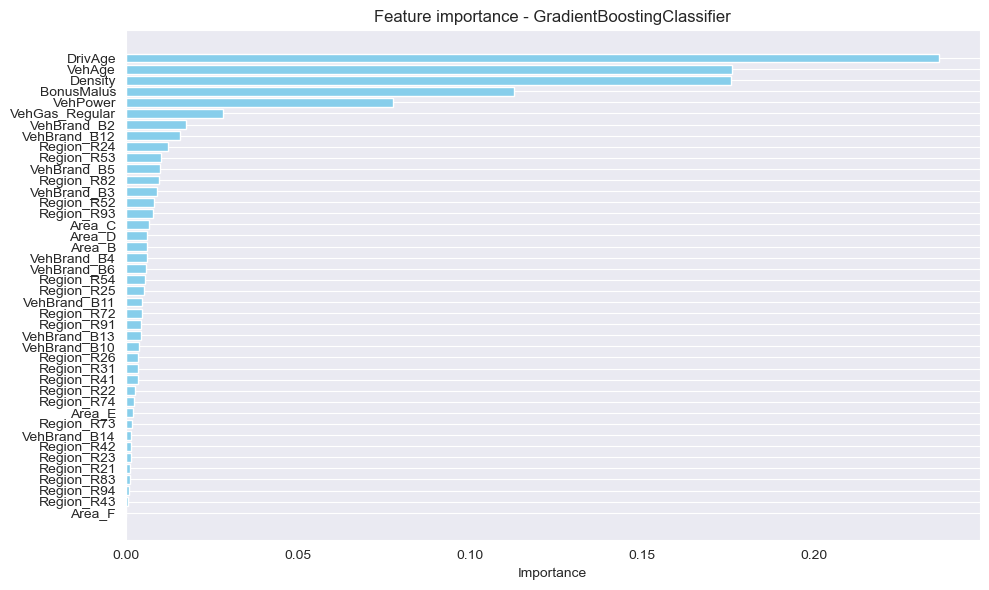

In [37]:
importances = model.feature_importances_
feature_names = X_train.columns

feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp['feature'], feat_imp['importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('Feature importance - GradientBoostingClassifier')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

## Catboost

Learning rate set to 0.146862
0:	learn: 0.5342833	total: 164ms	remaining: 2m 44s
1:	learn: 0.4304406	total: 186ms	remaining: 1m 32s
2:	learn: 0.3605571	total: 206ms	remaining: 1m 8s
3:	learn: 0.3144527	total: 228ms	remaining: 56.9s
4:	learn: 0.2845789	total: 250ms	remaining: 49.8s
5:	learn: 0.2644987	total: 272ms	remaining: 45s
6:	learn: 0.2509273	total: 292ms	remaining: 41.5s
7:	learn: 0.2417486	total: 311ms	remaining: 38.6s
8:	learn: 0.2350865	total: 333ms	remaining: 36.7s
9:	learn: 0.2305359	total: 354ms	remaining: 35.1s
10:	learn: 0.2271327	total: 376ms	remaining: 33.8s
11:	learn: 0.2250918	total: 395ms	remaining: 32.5s
12:	learn: 0.2233283	total: 422ms	remaining: 32s
13:	learn: 0.2218443	total: 442ms	remaining: 31.1s
14:	learn: 0.2206879	total: 463ms	remaining: 30.4s
15:	learn: 0.2199980	total: 485ms	remaining: 29.8s
16:	learn: 0.2195199	total: 509ms	remaining: 29.4s
17:	learn: 0.2189076	total: 527ms	remaining: 28.7s
18:	learn: 0.2185269	total: 548ms	remaining: 28.3s
19:	learn: 0.

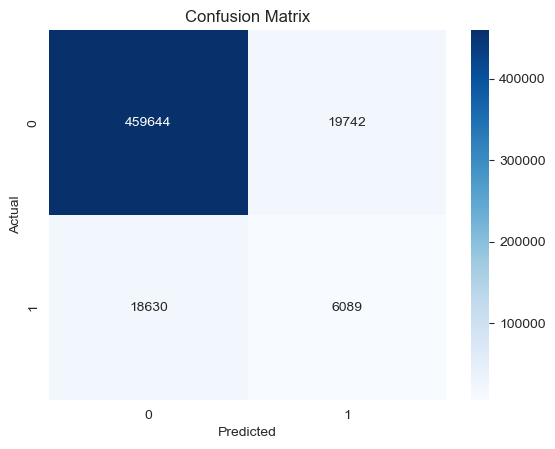

TEST-SET SCORING
ROC-AUC score: 0.6536855139861156
F1-score:  0.16312399355877616
Accuracy: 0.9175256095915955
Recall: 0.16674897119341564
Precision: 0.15965327029156817


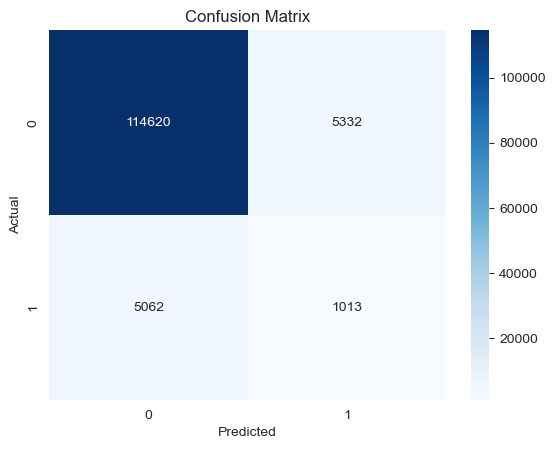

In [38]:
# Without tuning
model = CatBoostClassifier()
model.fit(X_train_val, y_train_val,sample_weight=exposure_train_val)
print("TRAIN-SET SCORING")

y_pred = model.predict_proba(X_train_val)[:,1]
stats = score_binary_model(y_train_val,y_pred)
models_stats_train['catboost_train'] = stats

print("TEST-SET SCORING")
y_pred = model.predict_proba(X_test)[:,1]
stats = score_binary_model(y_test,y_pred,models_stats_train['catboost_train']['best_threshold'])
models_stats_test['catboost_test'] = stats

In [39]:
# model = CatBoostClassifier(random_state=123)
# 
# search = BayesSearchCV(
#     estimator=model,
#     search_spaces={
#         'depth': (2, 15),
#         'learning_rate': (0.01, 0.2, 'log-uniform'),
#         'l2_leaf_reg': (1, 30),
#         'iterations': (100, 1000),
#         'bagging_temperature':(0,1),
#         'random_strength':(0,10)
#     },
#     scoring='roc_auc',
#     n_iter=50,
#     cv=3,
#     n_jobs=-1,
# )
# 
# search.fit(X_train_val, y_train_val)
# print("Best params:", search.best_params_)

- after 25 iterations
Best params: OrderedDict([('bagging_temperature', 1), ('depth', 8), ('iterations', 661), ('l2_leaf_reg', 8), ('learning_rate', 0.055324002607054404), ('random_strength', 0)])
- - after 50 
Best params: OrderedDict([('bagging_temperature', 1), ('depth', 9), ('iterations', 1000), ('l2_leaf_reg', 30), ('learning_rate', 0.04114929872310554), ('random_strength', 6)])

In [40]:
model = CatBoostClassifier(
    bagging_temperature=1,
    depth=9,
    iterations=1000,
    l2_leaf_reg=30,
    learning_rate=0.0411,
    random_strength=6
)
model.fit(X_train_val, y_train_val,sample_weight=exposure_train_val)

0:	learn: 0.6443211	total: 33.3ms	remaining: 33.3s
1:	learn: 0.6004508	total: 63.9ms	remaining: 31.9s
2:	learn: 0.5612470	total: 93.9ms	remaining: 31.2s
3:	learn: 0.5264801	total: 115ms	remaining: 28.6s
4:	learn: 0.4953951	total: 148ms	remaining: 29.5s
5:	learn: 0.4674723	total: 178ms	remaining: 29.5s
6:	learn: 0.4423572	total: 203ms	remaining: 28.8s
7:	learn: 0.4201514	total: 233ms	remaining: 28.9s
8:	learn: 0.4002230	total: 264ms	remaining: 29s
9:	learn: 0.3822781	total: 295ms	remaining: 29.2s
10:	learn: 0.3658688	total: 325ms	remaining: 29.3s
11:	learn: 0.3517220	total: 347ms	remaining: 28.5s
12:	learn: 0.3390683	total: 388ms	remaining: 29.4s
13:	learn: 0.3275759	total: 420ms	remaining: 29.6s
14:	learn: 0.3172607	total: 444ms	remaining: 29.1s
15:	learn: 0.3081285	total: 468ms	remaining: 28.8s
16:	learn: 0.2998245	total: 498ms	remaining: 28.8s
17:	learn: 0.2923740	total: 529ms	remaining: 28.9s
18:	learn: 0.2856986	total: 559ms	remaining: 28.9s
19:	learn: 0.2798037	total: 580ms	remain

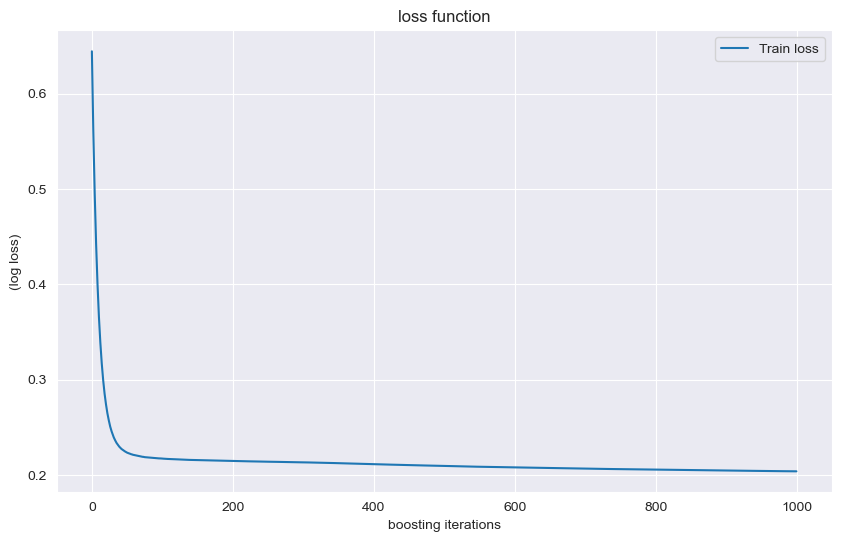

In [41]:
train_loss = model.get_evals_result()['learn']['Logloss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train loss')
plt.xlabel('boosting iterations')
plt.ylabel('(log loss)')
plt.title('loss function')
plt.legend()
plt.grid(True)
plt.show()

TRAIN-SET SCORING
ROC-AUC score: 0.713484418278108
F1-score:  0.22072519083969466
Accuracy: 0.918997034348003
Recall: 0.23394959343015495
Precision: 0.20891586286622593


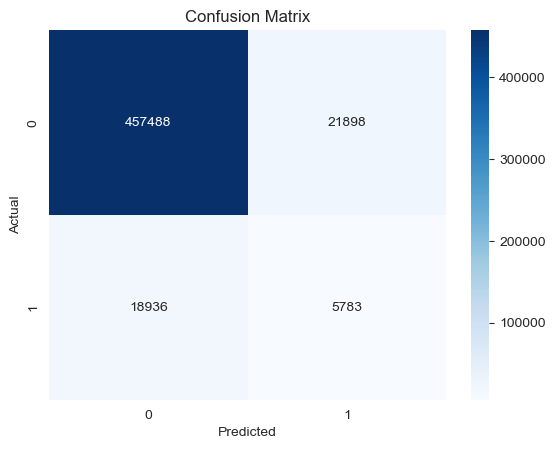

TRAIN-SET PLOTTING


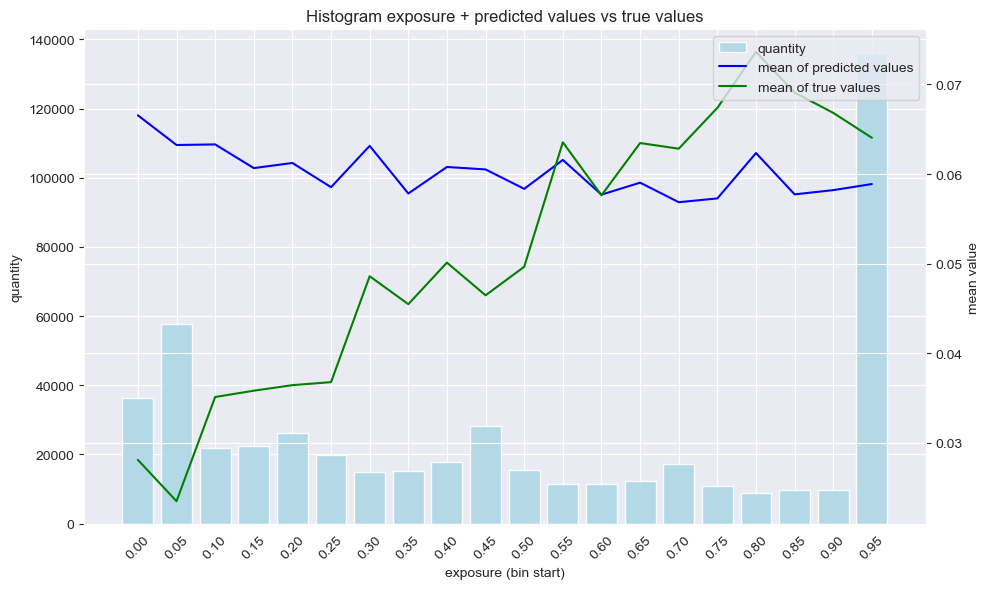

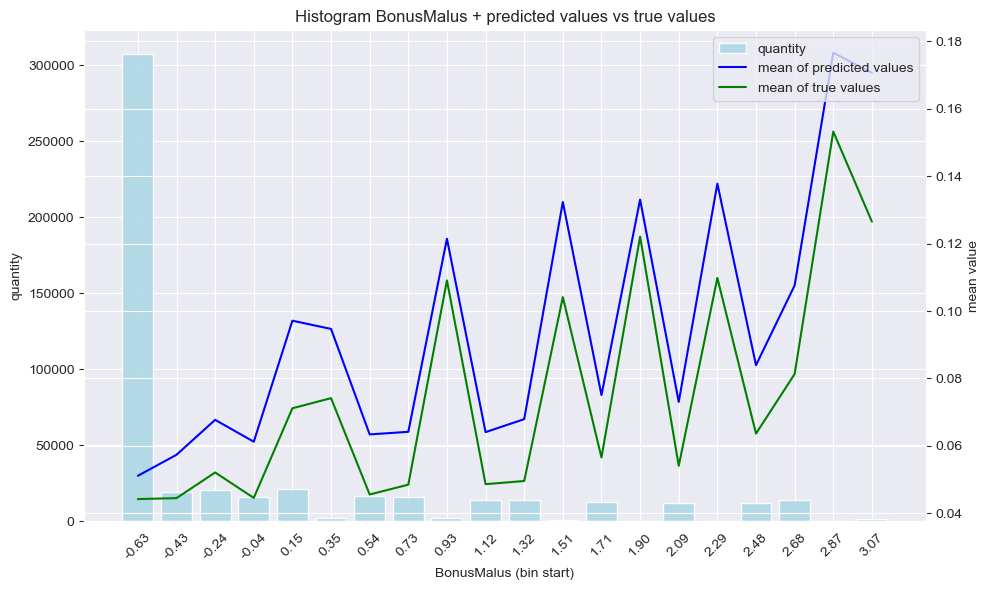

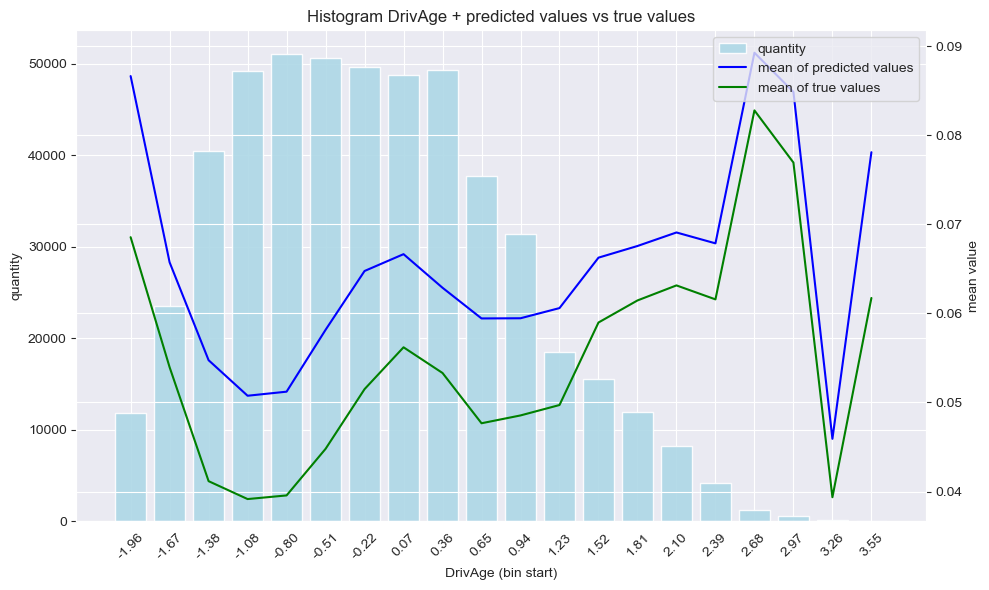

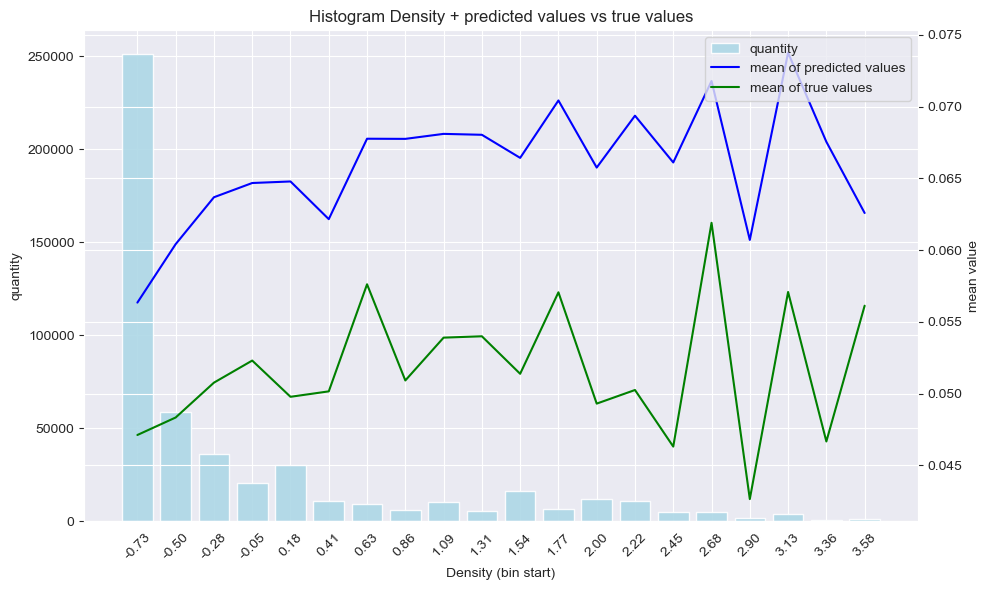

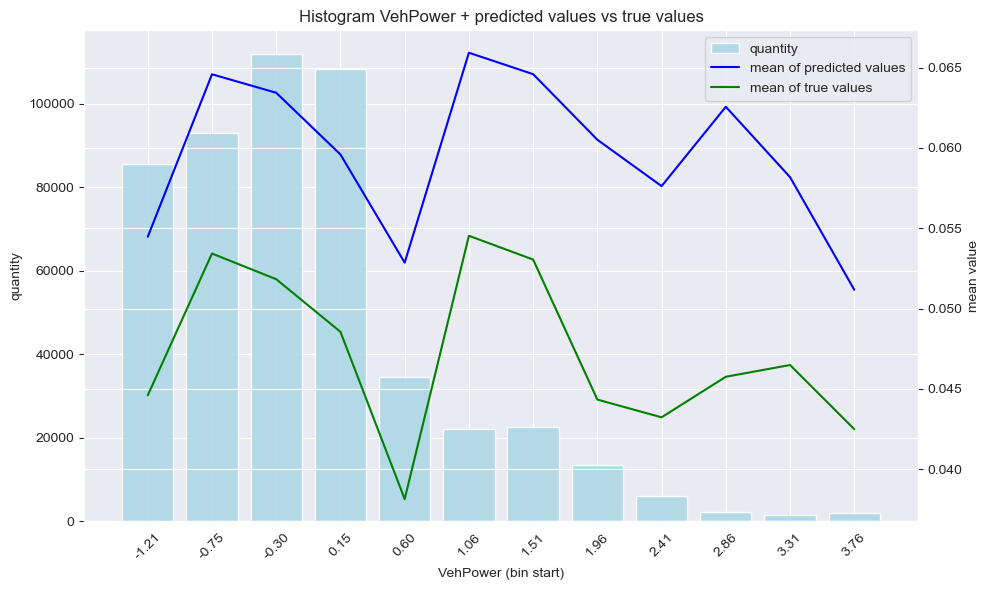

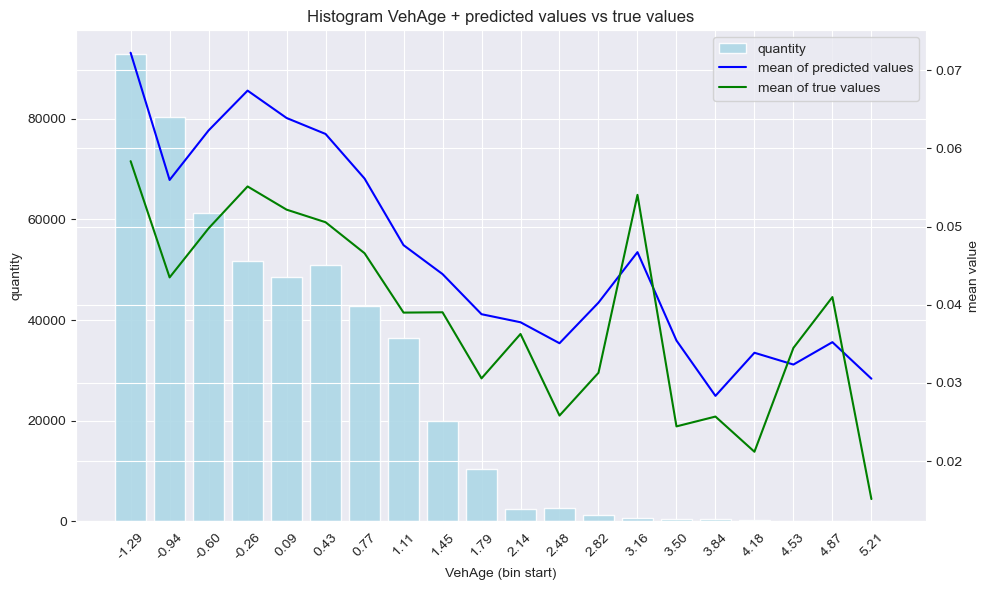

TEST-SET SCORING
ROC-AUC score: 0.6571653229192912
F1-score:  0.16589363017934447
Accuracy: 0.9143834257738421
Recall: 0.1766255144032922
Precision: 0.15639119661856873


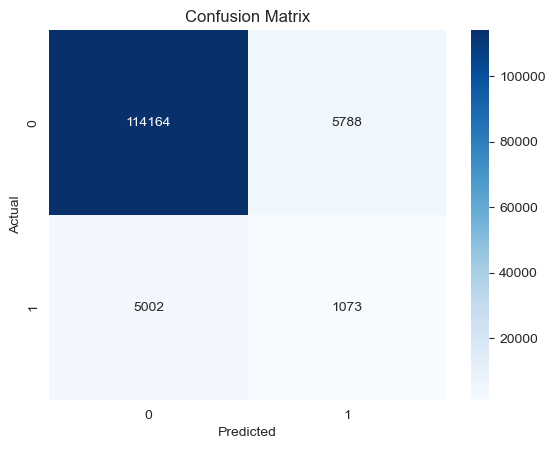

TEST-SET PLOTTING


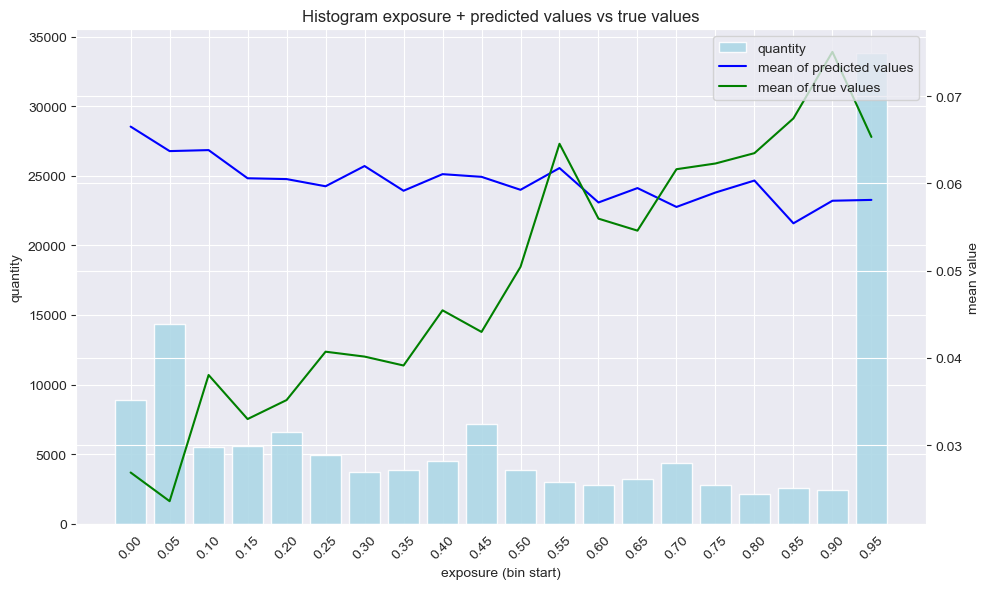

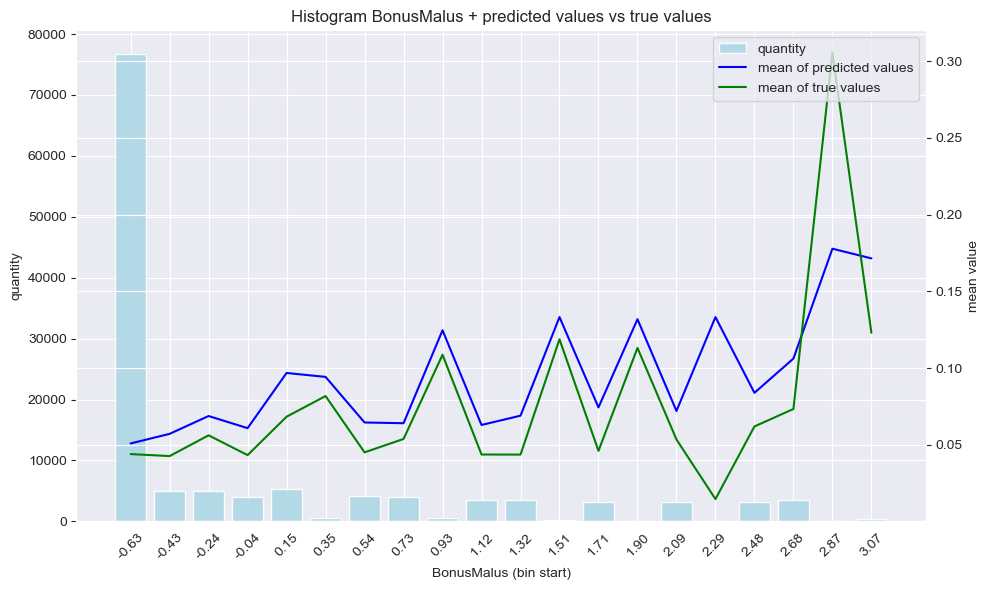

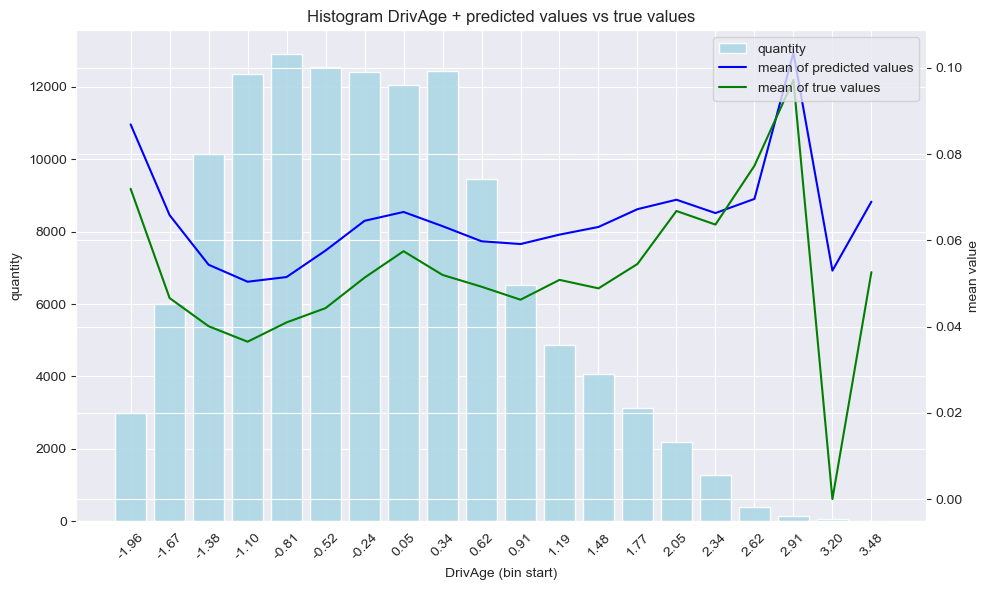

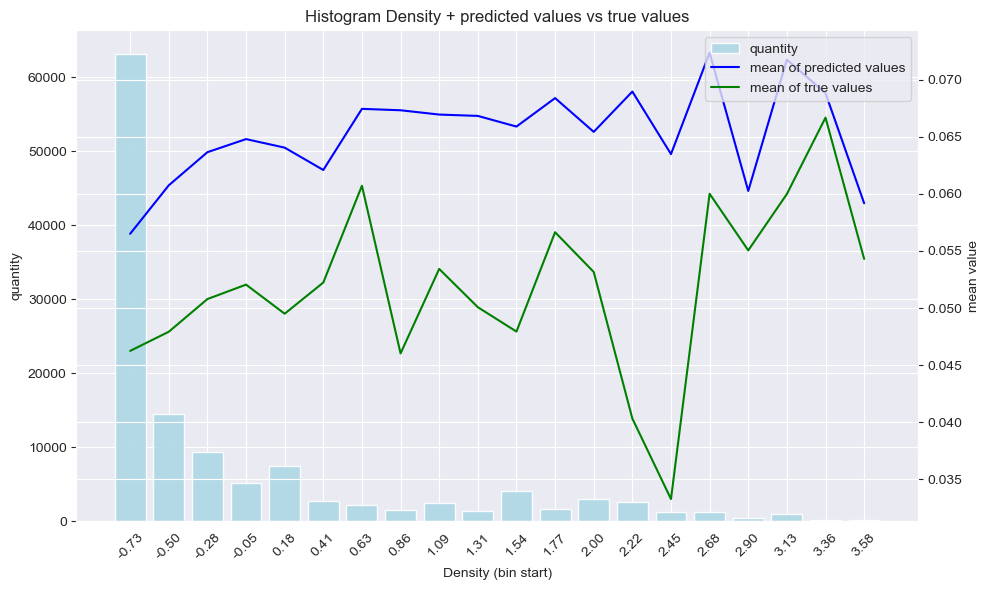

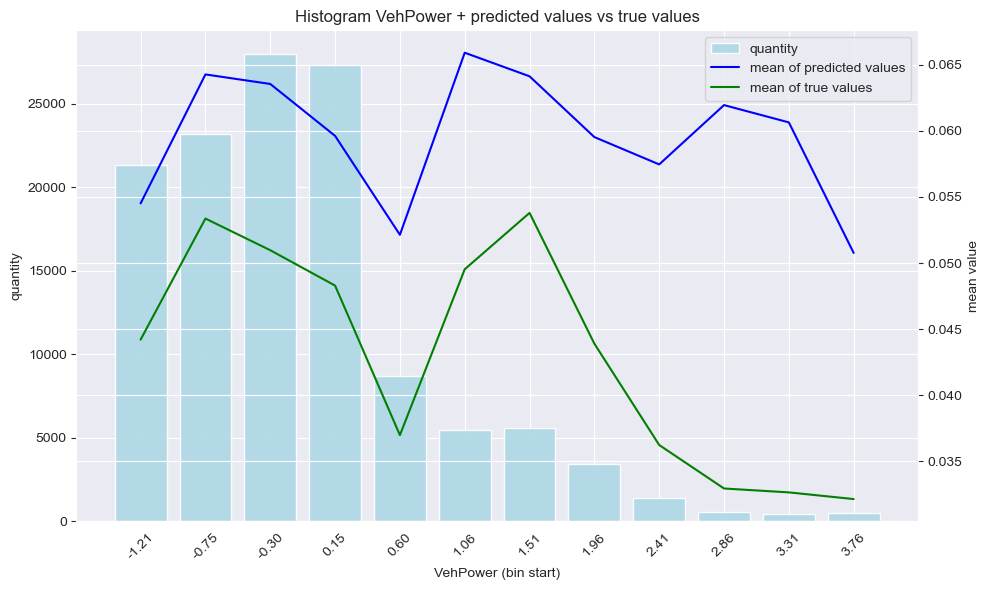

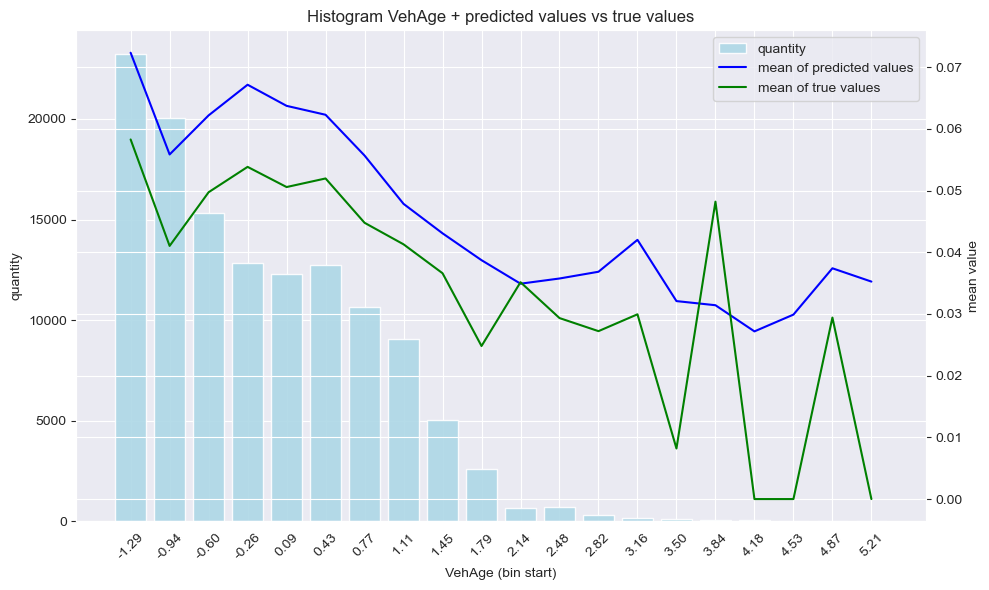

In [42]:
print("TRAIN-SET SCORING")
y_pred = model.predict_proba(X_train_val)[:,1]
stats = score_binary_model(y_train_val,y_pred)
models_stats_train['catboost_tuned_train'] = stats

print("TRAIN-SET PLOTTING")
plot_predict_with_feature(exposure_train_val_df,y_train_val,y_pred,'exposure')
for col in numeric_columns:
    plot_predict_with_feature(X_train_val,y_train_val,y_pred,col)
    
print("TEST-SET SCORING")
y_pred = model.predict_proba(X_test)[:,1]
stats = score_binary_model(y_test,y_pred,models_stats_train['catboost_tuned_train']['best_threshold'])
models_stats_test['catboost_tuned_test'] = stats

print("TEST-SET PLOTTING")
plot_predict_with_feature(exposure_test_df,y_test,y_pred,'exposure')
for col in numeric_columns:
    plot_predict_with_feature(X_test,y_test,y_pred,col)

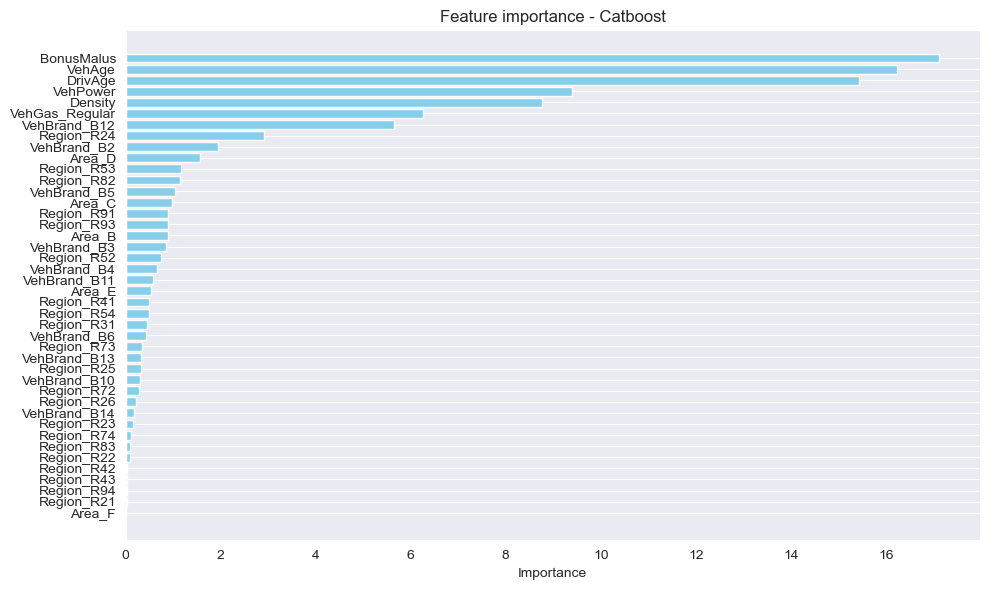

In [43]:
importances = model.feature_importances_
feature_names = X_train.columns

feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp['feature'], feat_imp['importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('Feature importance - Catboost')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

### catboost with more weighted target to improve recall

In [44]:
catboost = CatBoostClassifier(
    bagging_temperature=1,
    depth=9,
    iterations=1000,
    l2_leaf_reg=30,
    learning_rate=0.0411,
    random_strength=6
)
catboost.fit(X_train_val, y_train_val,sample_weight=weights_with_exposure_val_train)

0:	learn: 0.6915181	total: 32ms	remaining: 32s
1:	learn: 0.6897459	total: 62.6ms	remaining: 31.2s
2:	learn: 0.6883258	total: 91.8ms	remaining: 30.5s
3:	learn: 0.6867881	total: 120ms	remaining: 29.9s
4:	learn: 0.6854369	total: 150ms	remaining: 29.9s
5:	learn: 0.6841201	total: 181ms	remaining: 29.9s
6:	learn: 0.6831504	total: 212ms	remaining: 30.1s
7:	learn: 0.6821424	total: 246ms	remaining: 30.6s
8:	learn: 0.6810505	total: 277ms	remaining: 30.5s
9:	learn: 0.6799481	total: 308ms	remaining: 30.4s
10:	learn: 0.6791650	total: 338ms	remaining: 30.4s
11:	learn: 0.6783088	total: 359ms	remaining: 29.5s
12:	learn: 0.6775896	total: 388ms	remaining: 29.5s
13:	learn: 0.6769089	total: 415ms	remaining: 29.2s
14:	learn: 0.6762916	total: 445ms	remaining: 29.2s
15:	learn: 0.6755966	total: 469ms	remaining: 28.9s
16:	learn: 0.6750570	total: 498ms	remaining: 28.8s
17:	learn: 0.6743316	total: 530ms	remaining: 28.9s
18:	learn: 0.6737333	total: 561ms	remaining: 29s
19:	learn: 0.6731188	total: 592ms	remaining:

TRAIN-SET SCORING
ROC-AUC score: 0.7526426250937631
F1-score:  0.22440752504275593
Accuracy: 0.8992432132194682
Recall: 0.29726121606861117
Precision: 0.18023498246216488


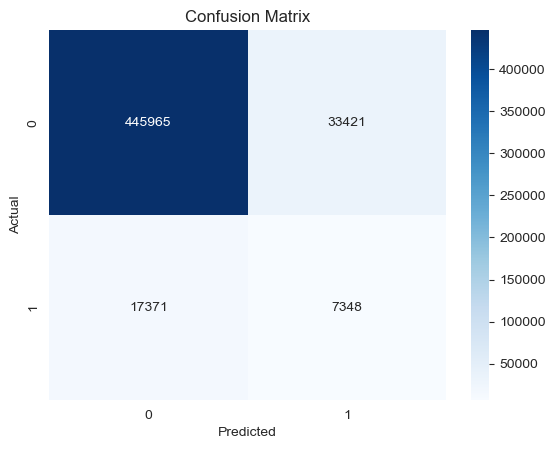

TRAIN-SET PLOTTING


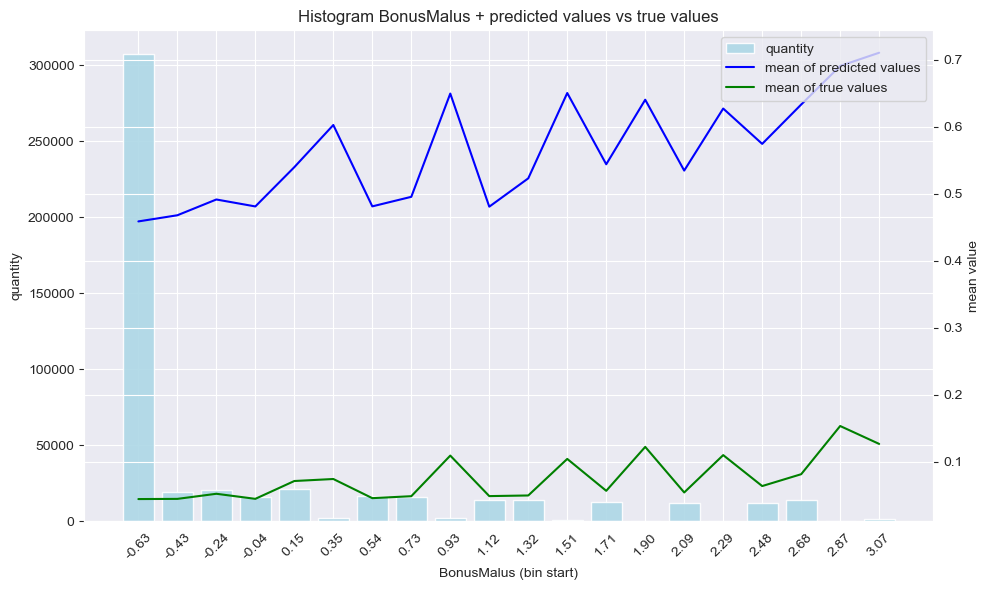

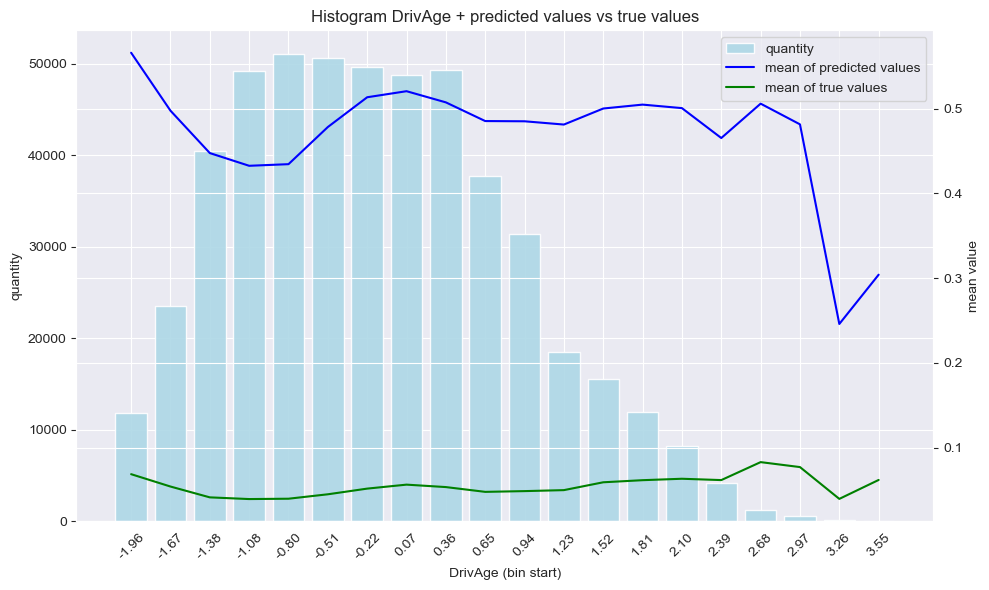

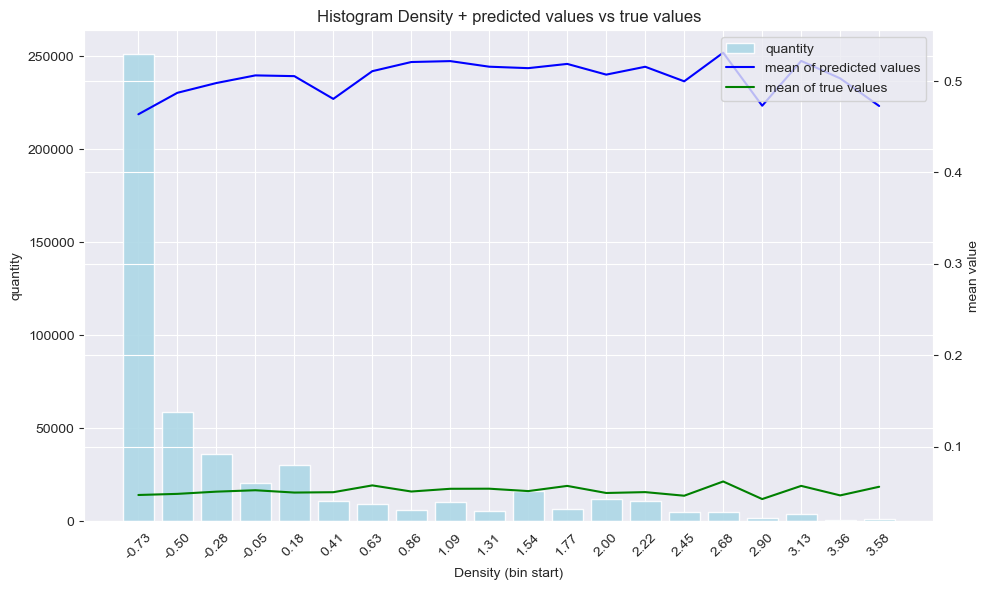

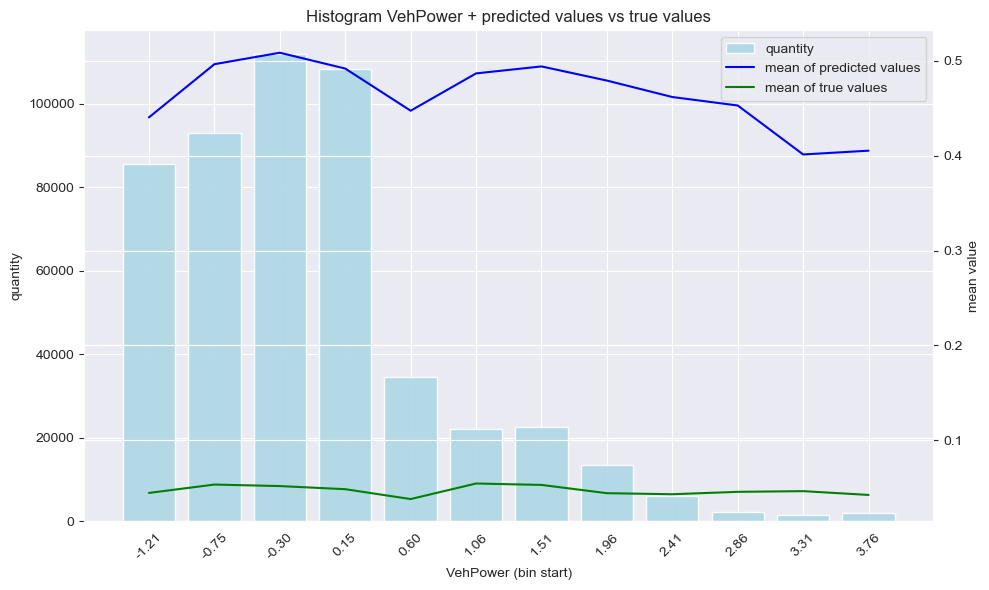

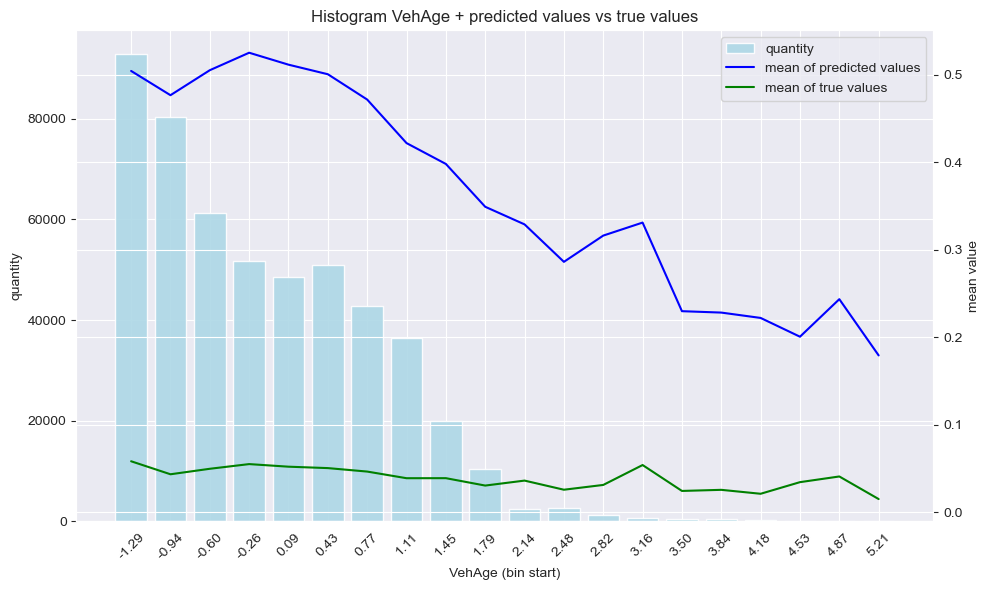

TEST-SET SCORING
ROC-AUC score: 0.6568305442890462
F1-score:  0.16840666169525229
Accuracy: 0.8938164044212749
Recall: 0.22304526748971193
Precision: 0.13527004093041828


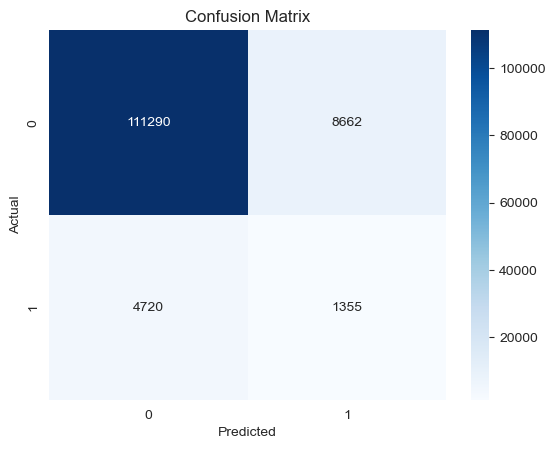

TEST-SET PLOTTING


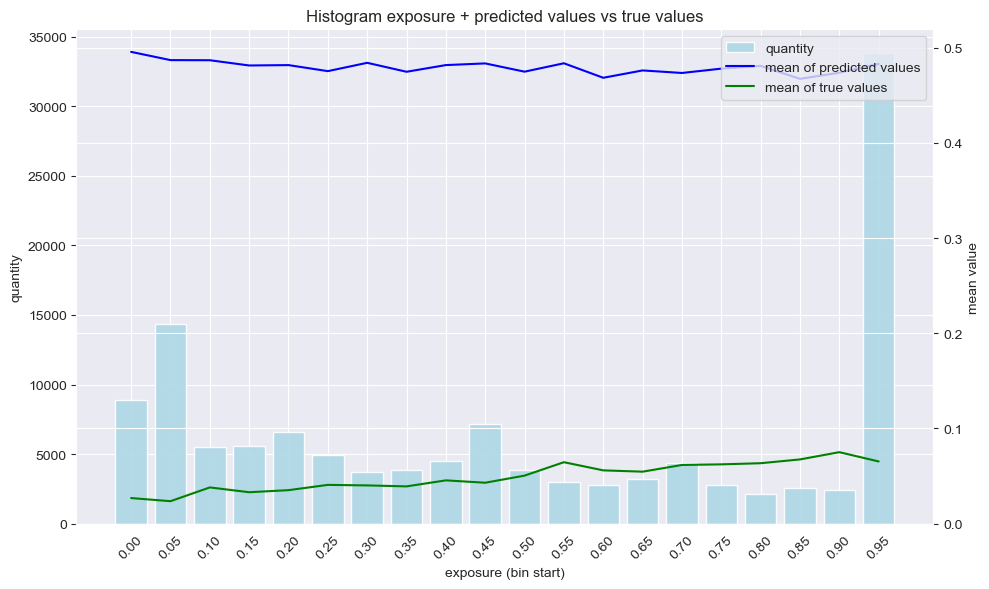

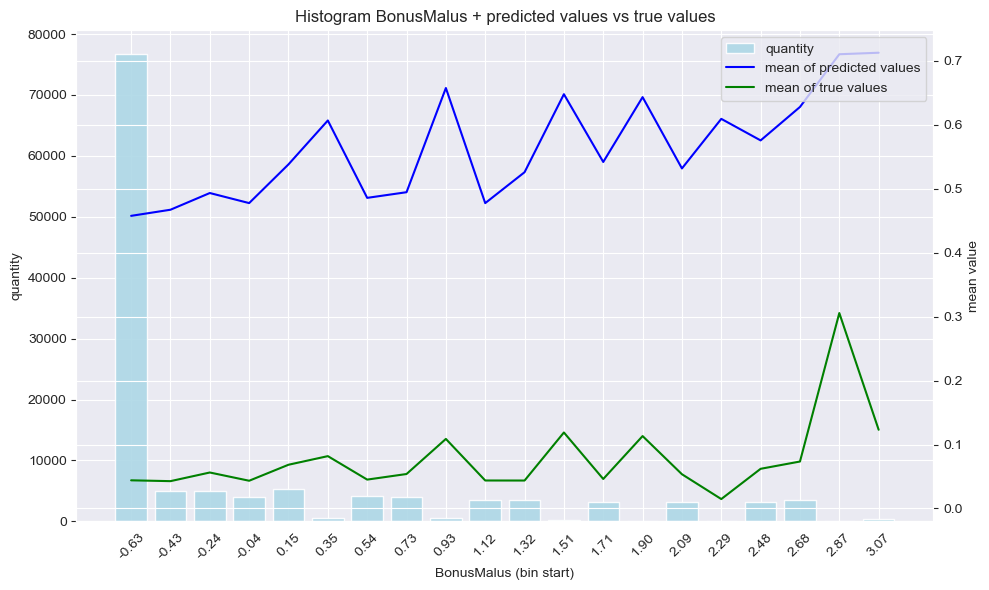

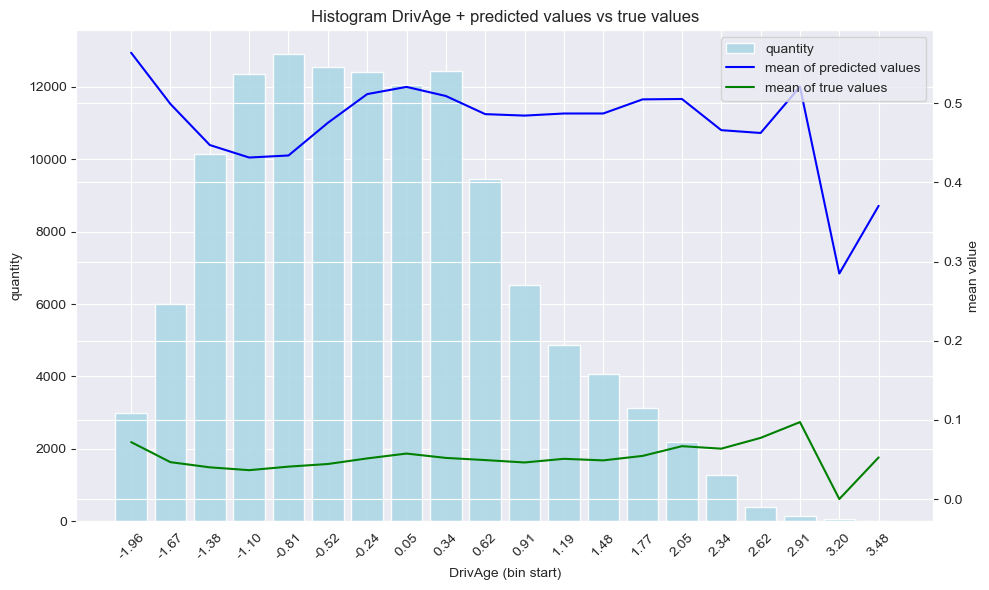

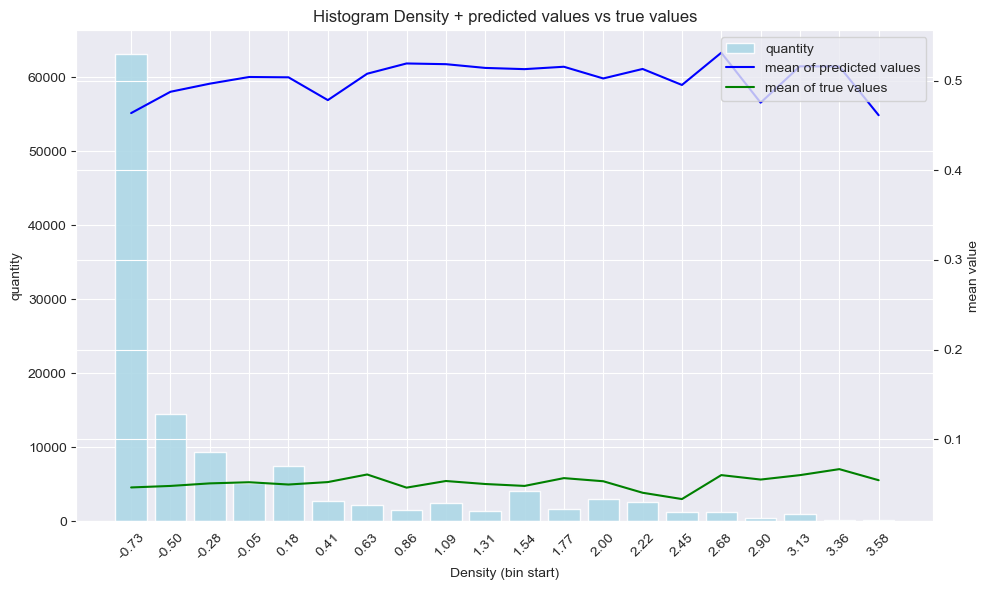

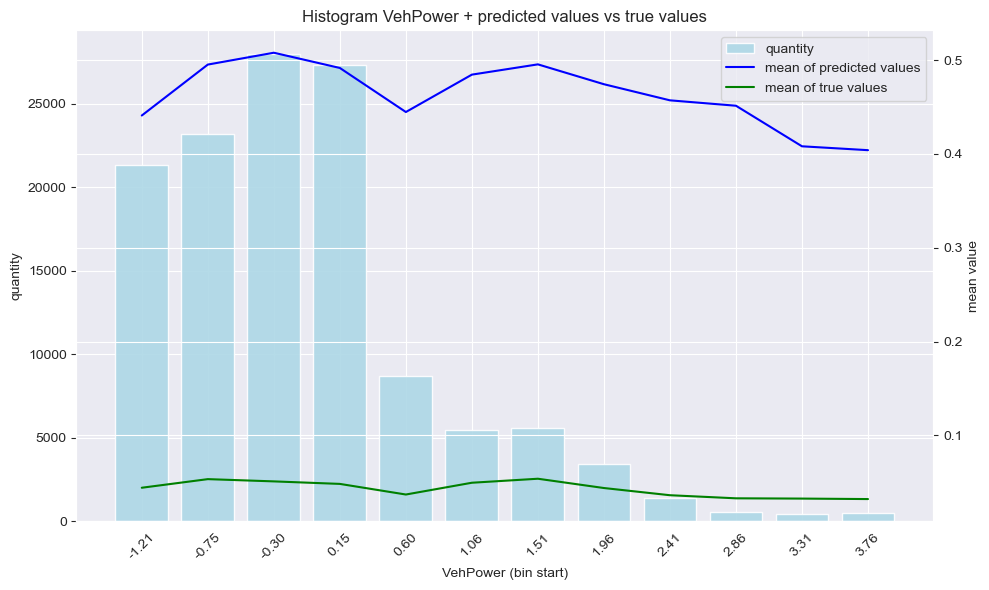

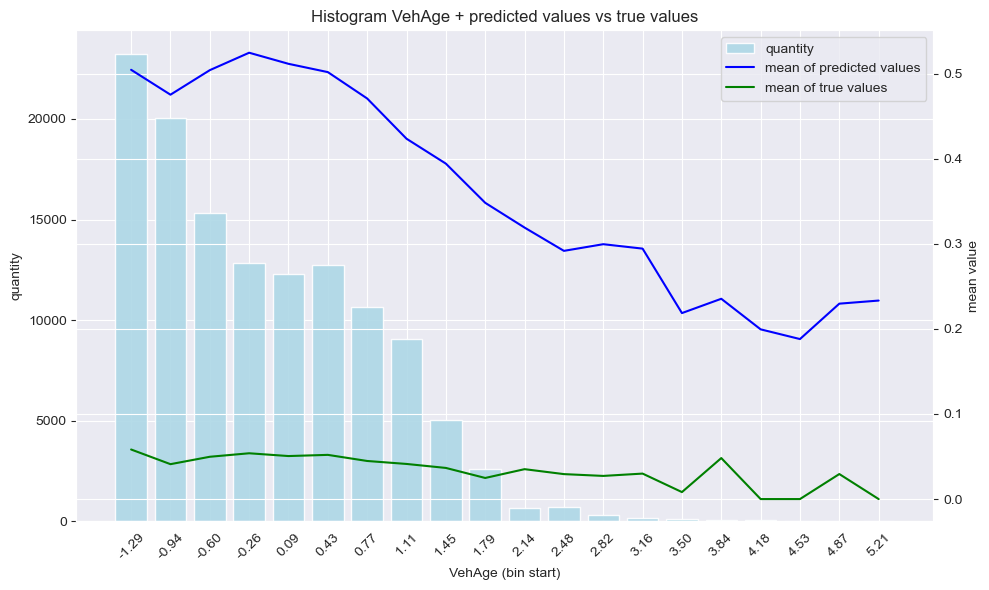

In [45]:
print("TRAIN-SET SCORING")
y_pred = catboost.predict_proba(X_train_val)[:,1]
stats = score_binary_model(y_train_val,y_pred)
models_stats_train['catboost_tuned_weighted_train'] = stats

print("TRAIN-SET PLOTTING")
#plot_predict_with_feature(exposure_train_val_df,y_train_val,y_pred,'exposure')
for col in numeric_columns:
    plot_predict_with_feature(X_train_val,y_train_val,y_pred,col)
    
print("TEST-SET SCORING")
y_pred = catboost.predict_proba(X_test)[:,1]
stats = score_binary_model(y_test,y_pred,models_stats_train['catboost_tuned_weighted_train']['best_threshold'])
models_stats_test['catboost_tuned_weighted_test'] = stats

print("TEST-SET PLOTTING")
plot_predict_with_feature(exposure_test_df,y_test,y_pred,'exposure')
for col in numeric_columns:
    plot_predict_with_feature(X_test,y_test,y_pred,col)

## xgboost

[0]	train-auc:0.62782	eval-auc:0.61691
[10]	train-auc:0.65102	eval-auc:0.63124
[20]	train-auc:0.66420	eval-auc:0.63811
[30]	train-auc:0.67427	eval-auc:0.64182
[40]	train-auc:0.68169	eval-auc:0.64441
[50]	train-auc:0.68770	eval-auc:0.64467
[60]	train-auc:0.69312	eval-auc:0.64587
[70]	train-auc:0.69764	eval-auc:0.64629
[80]	train-auc:0.70128	eval-auc:0.64625
[90]	train-auc:0.70502	eval-auc:0.64581
[97]	train-auc:0.70690	eval-auc:0.64578
TRAIN-SET SCORING
ROC-AUC score: 0.6985649867447855
F1-score:  0.19002385414891804
Accuracy: 0.899412556634989
Recall: 0.2402132356900544
Precision: 0.15718262217680842


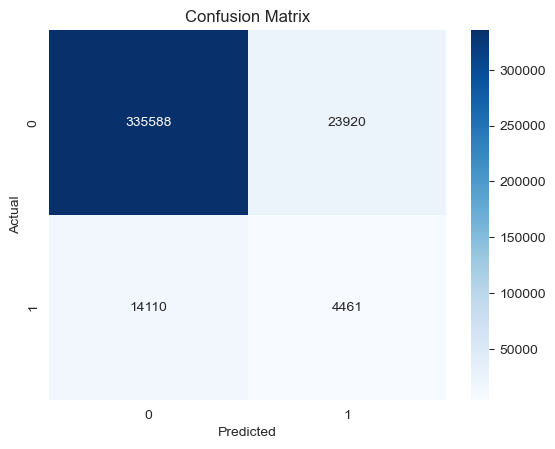

TEST-SET SCORING
ROC-AUC score: 0.6533876856641148
F1-score:  0.1618018251245874
Accuracy: 0.8972363065057488
Recall: 0.205761316872428
Precision: 0.13331911262798635


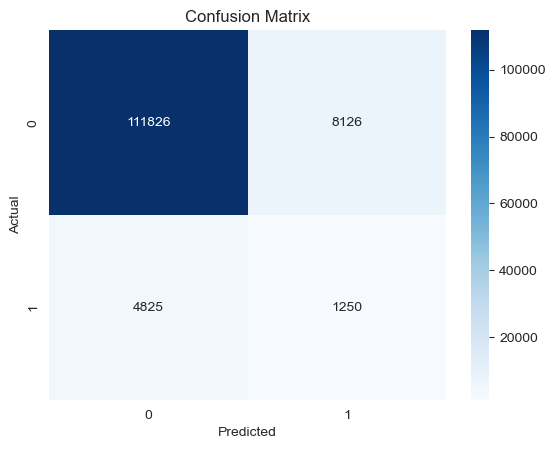

TRAIN-SET SCORING
ROC-AUC score: 0.8117111396027299
F1-score:  0.2839403584139477
Accuracy: 0.9094018111306176
Recall: 0.36631740766212223
Precision: 0.2318109671803799


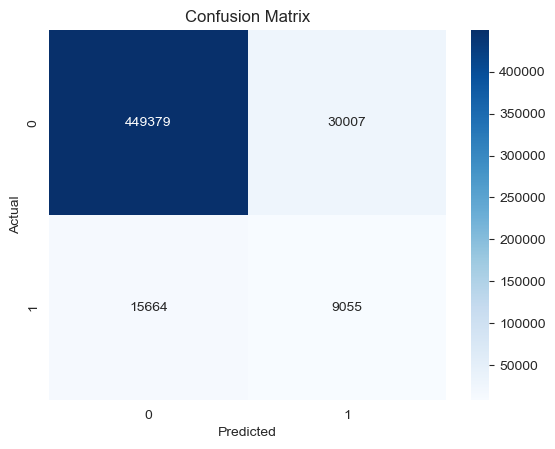

TEST-SET SCORING
ROC-AUC score: 0.6446998072205562
F1-score:  0.16267257098202656
Accuracy: 0.8979742436144635
Recall: 0.20559670781893005
Precision: 0.13457601551556944


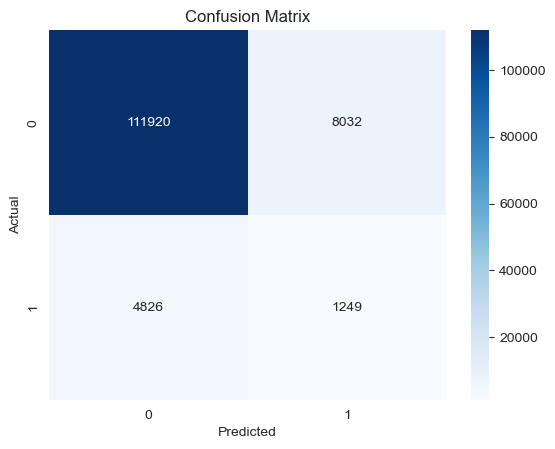

In [46]:
dtrain_val = xgb.DMatrix(X_train_val, label=y_train_val,weight=exposure_train_val)
dtrain = xgb.DMatrix(X_train, label=y_train,weight=exposure_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.1,
    'max_depth': 6,
    'scale_pos_weight': sum(y_train == 0) / sum(y_train == 1),
    'verbosity': 1
}

evallist = [(dtrain, 'train'), (dval, 'eval')]
model = xgb.train(params, dtrain, num_boost_round=1000, evals=evallist,
                  early_stopping_rounds=20, verbose_eval=10)

print("TRAIN-SET SCORING")
y_pred =  model.predict(dtrain)
stats = score_binary_model(y_train,y_pred)
models_stats_train['xgboost_es_train'] = stats

print("TEST-SET SCORING")
y_pred =  model.predict(dtest)
stats = score_binary_model(y_test,y_pred,models_stats_train['xgboost_es_train']['best_threshold'])
models_stats_test['xgboost_es_test'] = stats

# Training on bigger dataset, without earlystopping

model = xgb.train(params, dtrain_val, num_boost_round=1000,verbose_eval=10)

print("TRAIN-SET SCORING")
y_pred =  model.predict(dtrain_val)
stats = score_binary_model(y_train_val,y_pred)
models_stats_train['xgboost_train'] = stats

print("TEST-SET SCORING")
y_pred =  model.predict(dtest)
stats = score_binary_model(y_test,y_pred,models_stats_train['xgboost_train']['best_threshold'])
models_stats_test['xgboost_test'] = stats

## RandomForest

In [47]:
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train_val, y_train_val,sample_weight=exposure_train_val)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       n_jobs=-1, random_state=42)

TRAIN-SET SCORING
ROC-AUC score: 0.6003818422821053
F1-score:  0.11830264433061055
Accuracy: 0.39360252328383966
Recall: 0.8296452121849589
Precision: 0.06369240803143003


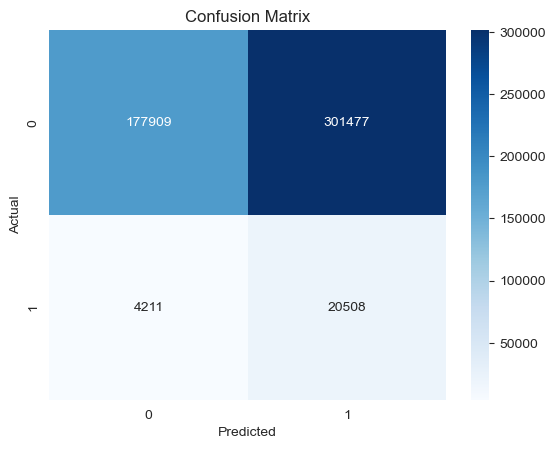

TEST-SET SCORING
ROC-AUC score: 0.583844772476892
F1-score:  0.11207984531128788
Accuracy: 0.39150340799987304
Recall: 0.7967078189300412
Precision: 0.06027997808000797


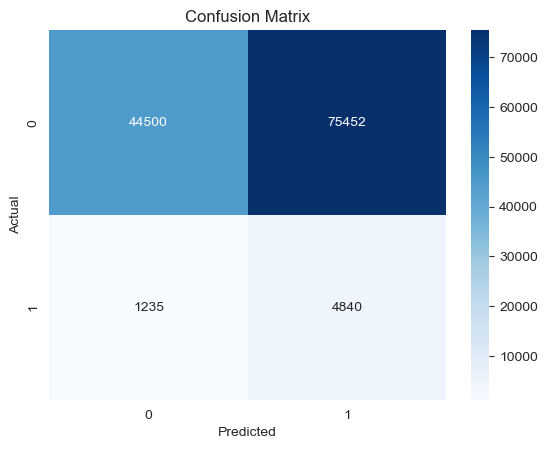

In [48]:
print("TRAIN-SET SCORING")
y_pred =  model.predict(X_train_val)
stats = score_binary_model(y_train_val,y_pred)
models_stats_train['randomforest_train'] = stats

print("TEST-SET SCORING")
y_pred =  model.predict(X_test)
stats = score_binary_model(y_test,y_pred,models_stats_train['randomforest_train']['best_threshold'])
models_stats_test['randomforest_test'] = stats

### Comparison of models (binary prediction)

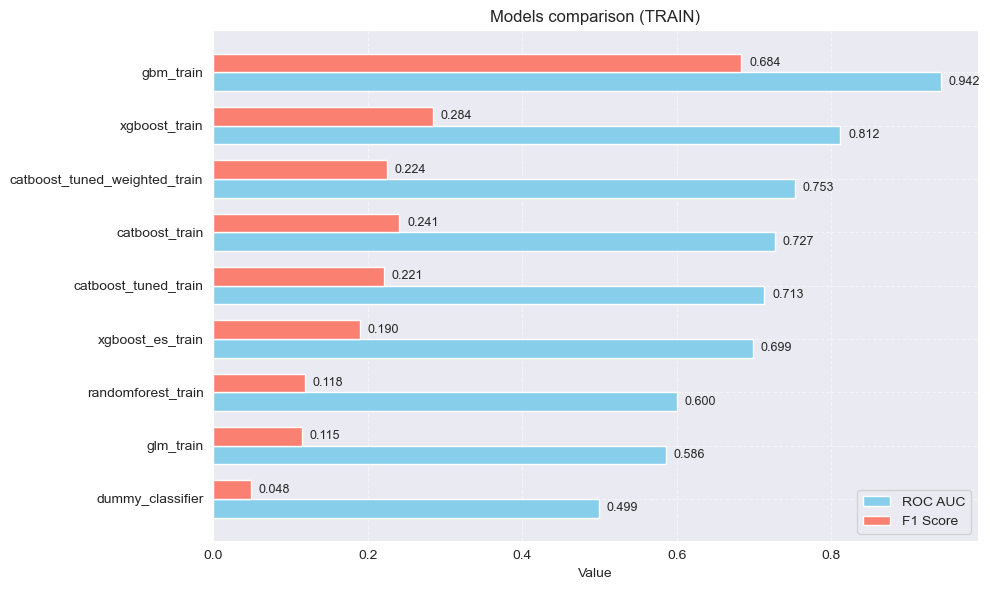

In [49]:
sorted_items = sorted(models_stats_train.items(), key=lambda x: x[1]['roc_auc_score'], reverse=False)

labels = [k for k, _ in sorted_items]
roc_aucs = [v['roc_auc_score'] for _, v in sorted_items]
f1_scores = [v['f1-score'] for _, v in sorted_items]

fig, ax = plt.subplots(figsize=(10, 6))
bar_height = 0.35
index = range(len(labels))

bars_roc = ax.barh(index, roc_aucs, bar_height, label='ROC AUC', color='skyblue')
bars_f1 = ax.barh([i + bar_height for i in index], f1_scores, bar_height, label='F1 Score', color='salmon')

for bar in bars_roc:
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
            f'{bar.get_width():.3f}', va='center', fontsize=9)

for bar in bars_f1:
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
            f'{bar.get_width():.3f}', va='center', fontsize=9)

ax.set_yticks([i + bar_height / 2 for i in index])
ax.set_yticklabels(labels)
ax.set_xlabel('Value')
ax.set_title('Models comparison (TRAIN)')
ax.legend(loc='lower right')

plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


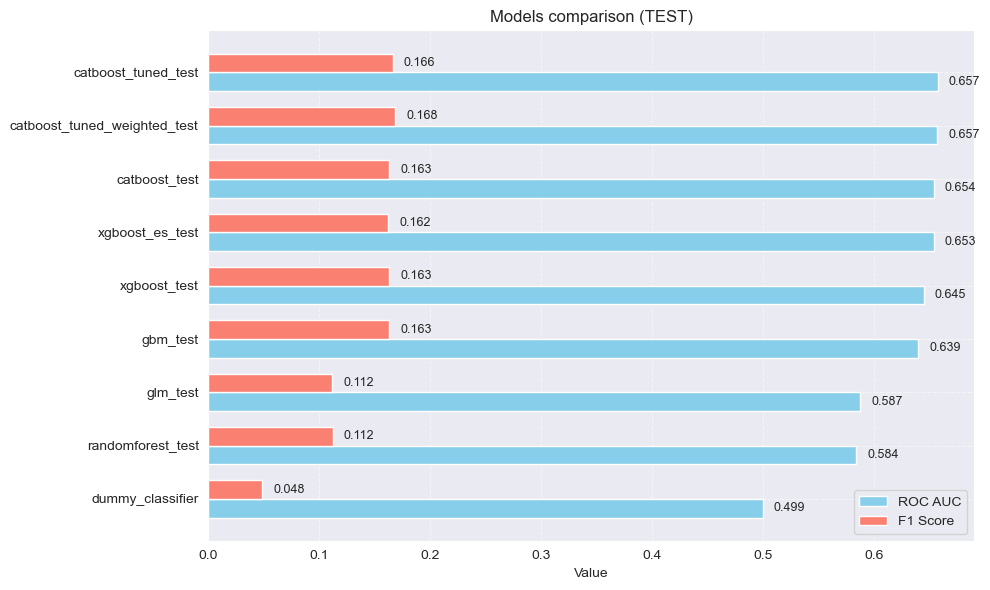

In [50]:
sorted_items = sorted(models_stats_test.items(), key=lambda x: x[1]['roc_auc_score'], reverse=False)

labels = [k for k, _ in sorted_items]
roc_aucs = [v['roc_auc_score'] for _, v in sorted_items]
f1_scores = [v['f1-score'] for _, v in sorted_items]

fig, ax = plt.subplots(figsize=(10, 6))
bar_height = 0.35
index = range(len(labels))

bars_roc = ax.barh(index, roc_aucs, bar_height, label='ROC AUC', color='skyblue')
bars_f1 = ax.barh([i + bar_height for i in index], f1_scores, bar_height, label='F1 Score', color='salmon')

for bar in bars_roc:
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
            f'{bar.get_width():.3f}', va='center', fontsize=9)

for bar in bars_f1:
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
            f'{bar.get_width():.3f}', va='center', fontsize=9)

ax.set_yticks([i + bar_height / 2 for i in index])
ax.set_yticklabels(labels)
ax.set_xlabel('Value')
ax.set_title('Models comparison (TEST)')
ax.legend(loc='lower right')

plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Explain the best model

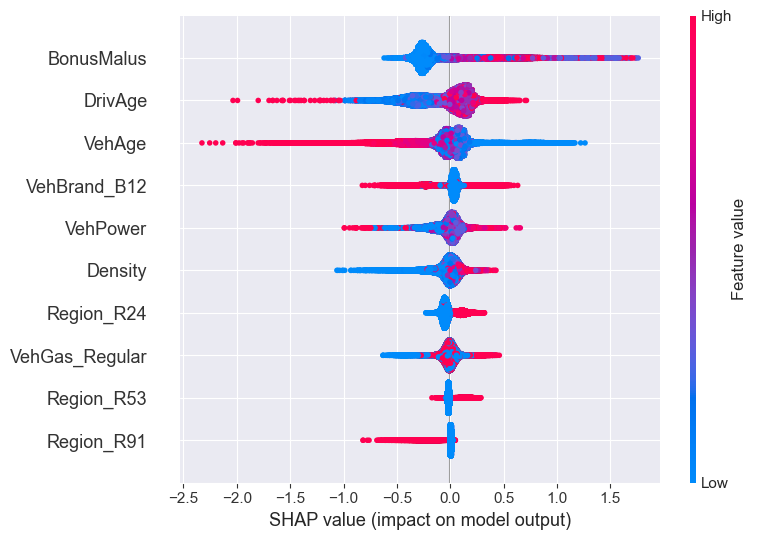

In [51]:
import shap

explainer = shap.TreeExplainer(catboost)
shap_values1 = explainer.shap_values(X_test)
shap.summary_plot(shap_values1, X_test, max_display=10)

logit(p)=log(p/(1-p)), models operates on logits because it's optimal for log-loss, logits are also symmetrical 

C:\Users\Aycon\AppData\Local\Temp\ipykernel_1256\210979638.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_row_og[numeric_columns] =  ss.inverse_transform(X_test.iloc[0:1][numeric_columns])


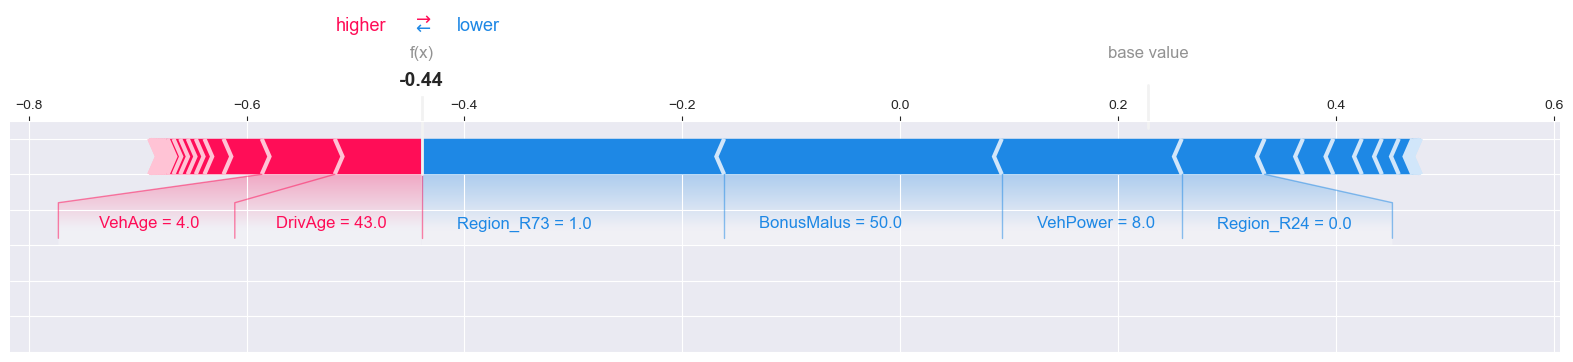

In [52]:
# revert the scaling
first_row_og = X_test.iloc[0:1]
first_row_og[numeric_columns] =  ss.inverse_transform(X_test.iloc[0:1][numeric_columns])

shap.force_plot(
    explainer.expected_value,
    shap_values1[0],
    first_row_og,
    matplotlib=True
)

In CatBoost, when you use .feature_importances_, the feature importance is typically computed using the "PredictionValuesChange" method by default.

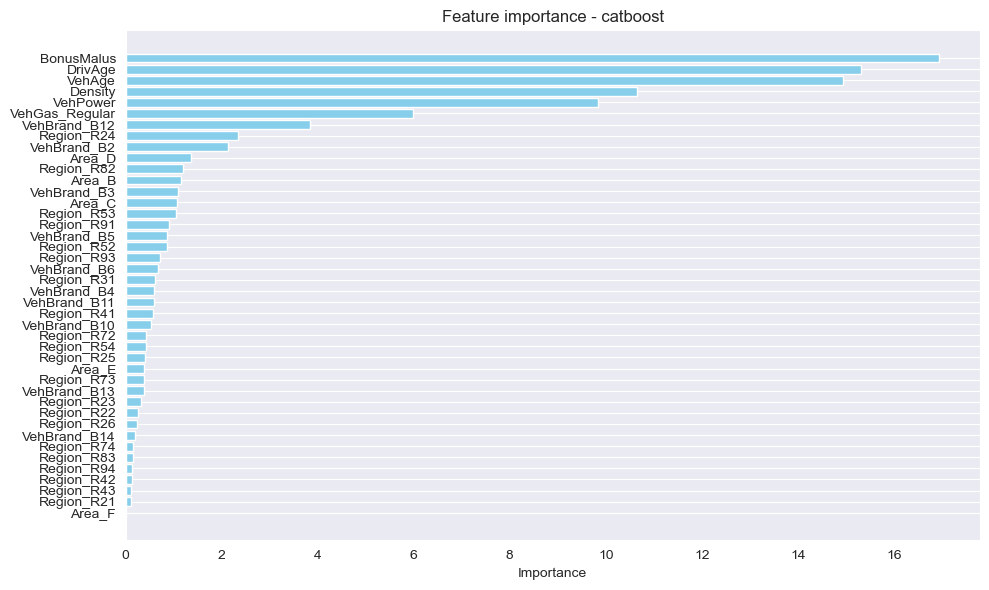

In [53]:
importances = catboost.feature_importances_
feature_names = X_train.columns

feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp['feature'], feat_imp['importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('Feature importance - catboost')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# What to improve
- pipeline (model + scaler in 1 go)
- more data from other sources could potentially help with overfitting.